In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from matplotlib import pyplot as plt

In [2]:
url = 'https://raw.githubusercontent.com/DanhBitoo/HanoiDaily-temperature/refs/heads/main/Hanoi%20Daily.csv'
df_daily = pd.read_csv(url)
df_daily.head()


,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Hanoi,2015-01-01,24.0,11.4,17.7,24.0,11.4,17.7,9.4,63.8,...,17.1,7,NaN,2015-01-01T06:33:34,2015-01-01T17:26:18,0.36,Clear,Clear conditions throughout the day.,clear-day,"48820099999,48823099999,48825099999,4883109999..."
1,Hanoi,2015-01-02,22.0,11.0,16.3,22.0,11.0,16.3,9.4,65.6,...,16.2,7,NaN,2015-01-02T06:33:53,2015-01-02T17:26:56,0.39,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48820099999,48823099999,48825099999,4883109999..."
2,Hanoi,2015-01-03,21.0,13.1,17.0,21.0,13.1,17.0,12.4,75.6,...,9.9,4,NaN,2015-01-03T06:34:11,2015-01-03T17:27:34,0.43,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48820099999,48823099999,48825099999,4883109999..."
3,Hanoi,2015-01-04,22.6,16.9,19.3,22.6,16.9,19.3,16.1,82.0,...,5.6,3,NaN,2015-01-04T06:34:28,2015-01-04T17:28:12,0.46,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"48820099999,48823099999,48825099999,4883109999..."
4,Hanoi,2015-01-05,23.0,18.5,20.4,23.0,18.5,20.4,18.4,88.4,...,7.9,4,NaN,2015-01-05T06:34:44,2015-01-05T17:28:51,0.50,Overcast,Cloudy skies throughout the day.,cloudy,"48820099999,48823099999,48825099999,4883109999..."


In [3]:
df_daily.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [4]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927 entries, 0 to 3926
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3927 non-null   object 
 1   datetime          3927 non-null   object 
 2   tempmax           3927 non-null   float64
 3   tempmin           3927 non-null   float64
 4   temp              3927 non-null   float64
 5   feelslikemax      3927 non-null   float64
 6   feelslikemin      3927 non-null   float64
 7   feelslike         3927 non-null   float64
 8   dew               3927 non-null   float64
 9   humidity          3927 non-null   float64
 10  precip            3927 non-null   float64
 11  precipprob        3927 non-null   int64  
 12  precipcover       3927 non-null   float64
 13  preciptype        2885 non-null   object 
 14  snow              3927 non-null   int64  
 15  snowdepth         3927 non-null   int64  
 16  windgust          3927 non-null   float64


# **Step 2**

## **Explain the meaning and values in each column**

| Feature Name | Description | Unit |
| :--- | :--- | :--- |
| name | The name of the location being recorded. | N/A (Text) |
| datetime | The specific date for the weather record. | N/A (Date/Time) |
| tempmax | The maximum temperature recorded for the day. | °C |
| tempmin | The minimum temperature recorded for the day. | °C |
| temp | The average temperature for the day. | °C |
| feelslikemax | The maximum "feels like" temperature, accounting for humidity and wind. | °C |
| feelslikemin | The minimum "feels like" temperature. | °C |
| feelslike | The average "feels like" temperature for the day. | °C |
| dew | The dew point temperature. This is the temperature at which air becomes saturated with water vapor. | °C |
| humidity | The average relative humidity for the day. | % |
| precip | The total amount of precipitation (e.g., rain) measured. | mm |
| precipprob | The probability of precipitation occurring on that day. | % |
| precipcover | The percentage of the day that precipitation was observed. | % |
| preciptype | The type(s) of precipitation observed. Can be a single value or a list. | N/A (Text) |
| snow | The amount of snowfall recorded. | mm |
| snowdepth | The depth of snow on the ground. | mm |
| windgust | The maximum wind gust speed recorded. | km/h |
| windspeed | The average wind speed for the day. | km/h |
| winddir | The average wind direction for the day (0-360), where 0/360 is North. | degrees (°) |
| sealevelpressure | The average sea-level atmospheric pressure. | mb |
| cloudcover | The average percentage of the sky covered by clouds. | % |
| visibility | The average visibility distance. | km |
| solarradiation | The average amount of solar radiation received. | W/m² |
| solarenergy | The total solar energy for the day. | MJ/m² |
| uvindex | The maximum UV (ultraviolet) index for the day on a scale from 0 upwards. | N/A (Scale) |
| severerisk | A rating of the risk for severe weather events (e.g., thunderstorms) on a scale. | N/A (Scale) |
| sunrise | The time of sunrise on that day. | N/A (Time) |
| sunset | The time of sunset on that day. | N/A (Time) |
| moonphase | The phase of the moon on a scale from 0 to 1 (0 is New Moon, 0.5 is Full Moon). | N/A (Scale) |
| conditions | A brief, comma-separated summary of the weather conditions for the day. | N/A (Text) |
| description | A more detailed, human-readable sentence describing the day's weather. | N/A (Text) |
| icon | A short text string representing a weather icon for use in applications. | N/A (Text) |
| stations | A list of weather station IDs that contributed data for that day's record. | N/A (List) |

## **Plot the target column (Hanoi temperature)**

In [5]:
df_daily['datetime'] = pd.to_datetime(df_daily['datetime'])
df_daily = df_daily.sort_values('datetime')

In [6]:
df_daily['temp'].isnull().sum()

np.int64(0)

### **Line Plot: Hanoi temperature trends by day for the last 10 years**

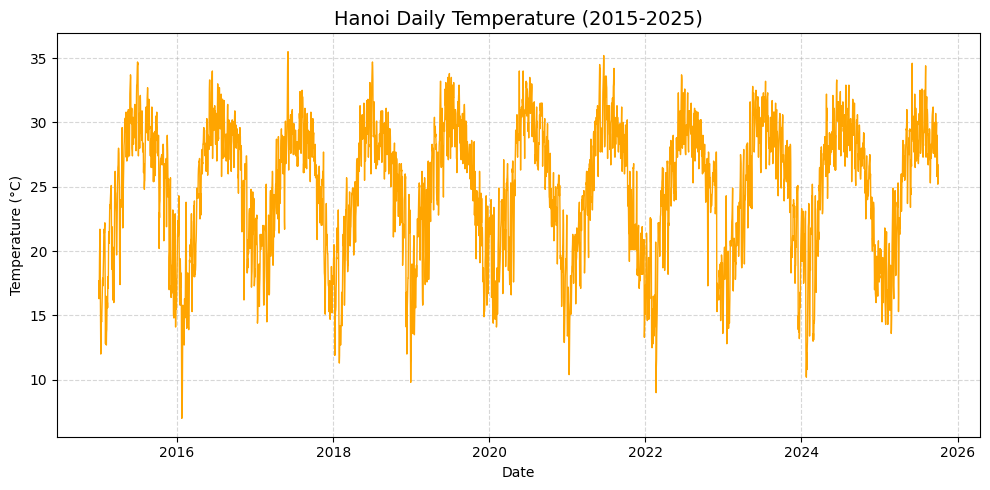

In [7]:
plt.figure(figsize=(10,5))
plt.plot(df_daily['datetime'], df_daily['temp'], color='orange', linewidth=1)
plt.title("Hanoi Daily Temperature (2015-2025)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Observation:**

- The chart exhibits clear seasonal cycles, which reflect Hanoi’s tropical monsoon climate:
    + Temperature rises sharply during summer (May-August).
    + Drops noticeably during winter (December-February).
- The repeating up-and-down pattern shows strong yearly seasonality.
- There is no clear long-term increase or decrease, but several unusually high peaks appear in recent years, possibly due to urban heat and climate change.

**Evaluation:**

→ This plot is highly meaningful for understanding short-term (daily) variations and seasonal patterns, but not ideal for identifying long-term trends due to the high data density.

* Very important for analyzing time cycles (seasonality).Forecasting models (e.g., LSTM, Prophet, ARIMA) need to understand that temperature repeats in yearly cycles.

* Helps detect short-term trends, seasonal patterns, and unusual fluctuations (spikes).

(Limitation: If the data is too detailed, it needs further processing (rolling mean, resampling) before training.)

→ This is the most useful chart for training a time-based weather prediction model.

### **Line Plot + Bar Plot: Hanoi's average temperature trends by year for the last 10 years**

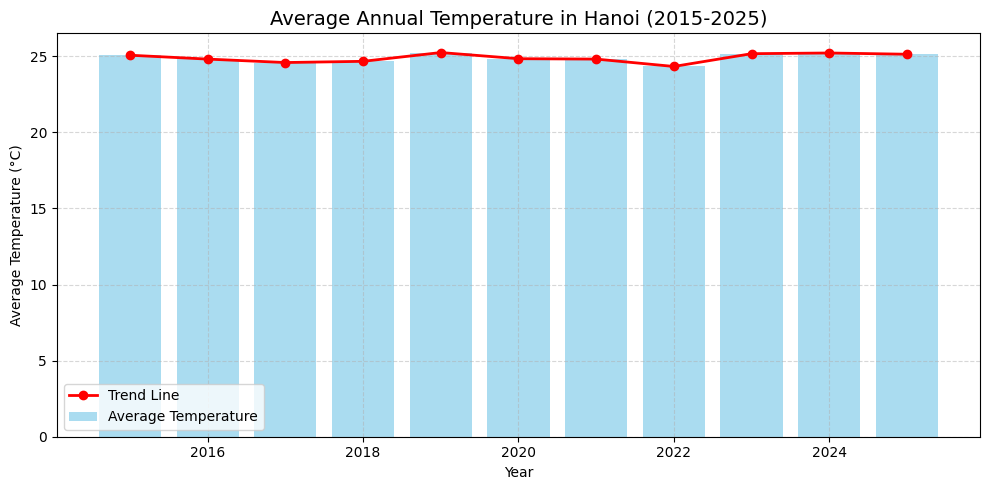

    year       temp
0   2015  25.074247
1   2016  24.819126
2   2017  24.592877
3   2018  24.672603
4   2019  25.249863
5   2020  24.844262
6   2021  24.819452
7   2022  24.334795
8   2023  25.174795
9   2024  25.220765
10  2025  25.138686


In [8]:
# Compute average temperature per year
yearly_avg = (
    df_daily.groupby(df_daily['datetime'].dt.year)['temp']
    .mean()
    .reset_index()
    .rename(columns={'datetime': 'year'})
)

# Plot line + bar chart to show long-term trend
plt.figure(figsize=(10, 5))
plt.bar(yearly_avg['year'], yearly_avg['temp'], color='skyblue', alpha=0.7, label='Average Temperature')
plt.plot(yearly_avg['year'], yearly_avg['temp'], color='red', marker='o', linewidth=2, label='Trend Line')

plt.title("Average Annual Temperature in Hanoi (2015-2025)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Print yearly averages
print(yearly_avg)

**Observation:**

- The average annual temperature stays around 24.8–25.2 °C, showing very little change across the 10 years.
- Minor fluctuations occur, with slightly higher averages in 2019 and 2024, but the overall trend remains stable.

**Evaluation:**

→ This chart is the most informative for analyzing long-term (yearly) trends.

→ The bars show each year’s specific value, while the red line visualizes the overall direction of change.

→ It is highly recommended for inclusion in the report’s Data Understanding or Trend Analysis section.

### **Line Plot: Hanoi's average monthly temperature for the last 10 years**

/tmp/ipython-input-1011380788.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


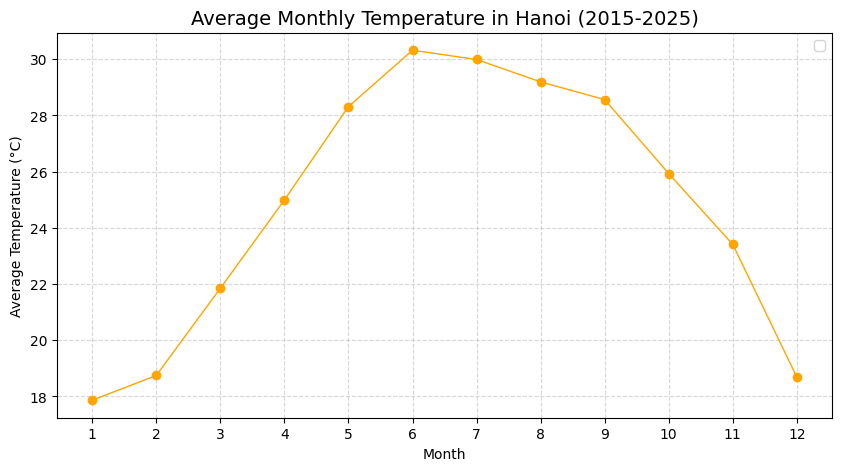

In [9]:
monthly_avg = df_daily.groupby(df_daily['datetime'].dt.month)['temp'].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', color='orange', linewidth=1)
plt.title("Average Monthly Temperature in Hanoi (2015-2025)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Average Temperature (°C)")
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

**Observation**

From the Average Monthly Temperature plot, the temperature progression across months displays a well-defined seasonal cycle.
- The lowest temperatures occur in January and February, averaging around 18–19°C, which corresponds to the winter months in northern Vietnam.
- Temperatures begin to rise sharply in March and April, signaling the transition to spring and early summer.
- The hottest months are June and July, with mean temperatures reaching approximately 30–31°C, occasionally even higher on certain days.
- After July, the temperature gradually decreases through August to November, marking the autumn period.
- By December, the temperature drops back to around 19°C, completing the yearly cycle.

**Evaluation**

This pattern indicates a strong thermal seasonality, with roughly a 12°C difference between the coldest and hottest months, emphasizing the distinct contrast between Hanoi’s hot and humid summers and its mild but cool winters.

### **Bar Plot: Hanoi's average seasonal temperature for the last 10 years**

In [10]:
def get_season(month):
    if month in [2, 3, 4]:
        return 'Spring'
    elif month in [5, 6, 7]:
        return 'Summer'
    elif month in [8, 9, 10]:
        return 'Autumn'
    else:
        return 'Winter'

/tmp/ipython-input-3439092894.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_avg.index, y=season_avg.values, palette='coolwarm')


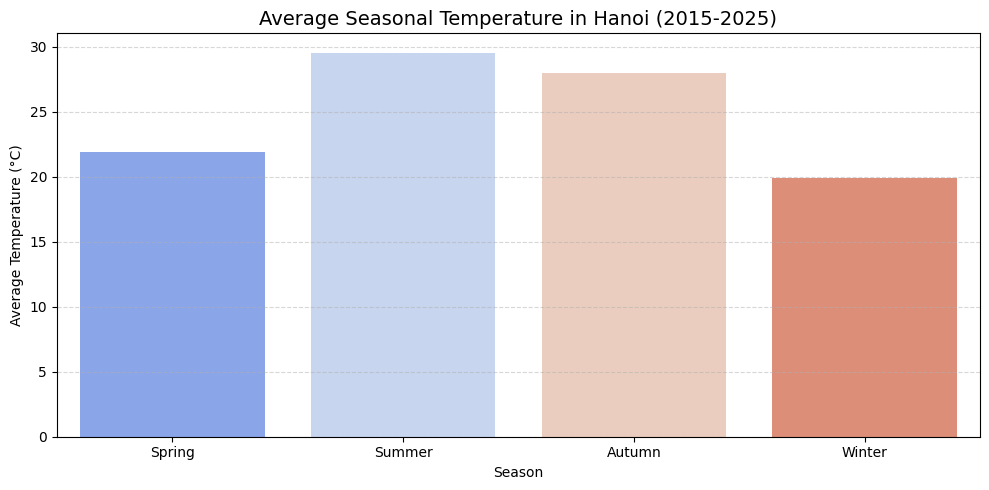

In [11]:
season_series = df_daily['datetime'].dt.month.map(get_season)
season_avg = df_daily.groupby(season_series)['temp'].mean().reindex(['Spring', 'Summer', 'Autumn', 'Winter'])

plt.figure(figsize=(10, 5))
sns.barplot(x=season_avg.index, y=season_avg.values, palette='coolwarm')
plt.title("Average Seasonal Temperature in Hanoi (2015-2025)", fontsize=14)
plt.xlabel("Season")
plt.ylabel("Average Temperature (°C)")
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.tight_layout()
plt.show()

**Observation**

The Average Temperature by Season chart provides further confirmation of these trends:
- Summer (May–July) is by far the hottest period, with an average temperature close to 30°C.
- Winter (November–January) is the coolest season, with an average around 20°C.
- Spring (February–April) and Autumn (August–October) are transitional periods, showing moderate temperatures of approximately 22–28°C, offering relatively comfortable weather conditions.

**Evaluation**

This clear temperature distinction between seasons highlights Hanoi’s typical monsoonal pattern, influenced by both continental cold air masses in winter and maritime tropical airflows in summer.

### **Rolling mean of Hanoi temperature (30-day Window) for the last 10 years**

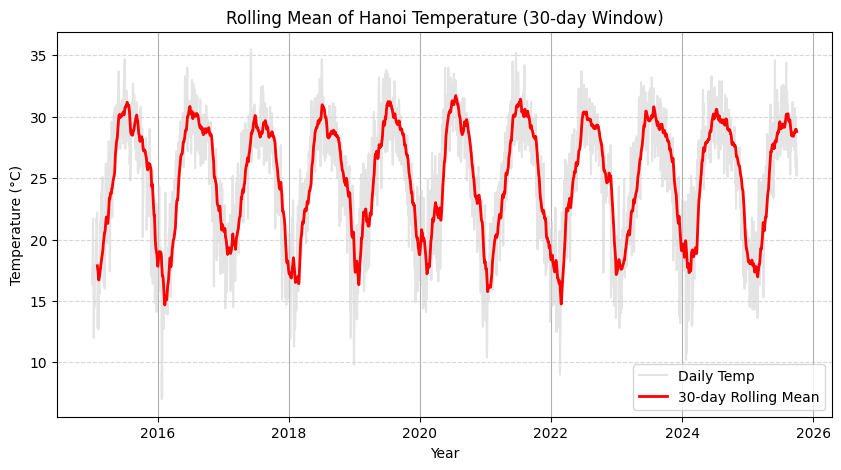

In [12]:
rolling_temp = df_daily['temp'].rolling(window=30).mean()

plt.figure(figsize=(10,5))
plt.plot(df_daily['datetime'], df_daily['temp'], color='lightgray', alpha=0.6, label='Daily Temp')
plt.plot(df_daily['datetime'], rolling_temp, color='red', label='30-day Rolling Mean', linewidth=2)
plt.title('Rolling Mean of Hanoi Temperature (30-day Window)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.grid(True)
plt.show()


The 30-day Rolling Mean Plot illustrates the temperature variation over time, smoothed to highlight broader trends while filtering out daily fluctuations. Each year exhibits a consistent pattern, peaking every summer and dipping every winter.

Notably:
- There is no significant long-term upward or downward trend in the average temperature over the 10-year period.
- This indicates that, while annual temperature cycles remain stable, short-term anomalies (such as unusually hot summers or mild winters) occasionally appear, but they do not accumulate into a persistent trend.

## **Relationship between different features of weather**

In [13]:
# Select only numeric columns for correlation matrix
numeric_df = df_daily.select_dtypes(include=["float64", "int64"])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()
corr_matrix

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
tempmax,1.000000,0.909259,0.977722,0.964647,0.889029,0.954692,0.843814,0.011194,0.056500,0.069758,...,0.155296,0.178907,-0.831940,-0.348941,0.423594,0.704166,0.703921,0.670989,0.631045,-0.004808
tempmin,0.909259,1.000000,0.969581,0.910259,0.963060,0.942145,0.932995,0.226346,0.130930,0.251155,...,0.155355,0.131802,-0.873497,-0.072704,0.351907,0.491328,0.491023,0.461985,0.634639,0.004376
temp,0.977722,0.969581,1.000000,0.957785,0.942461,0.974478,0.902911,0.100473,0.090129,0.150019,...,0.153572,0.160796,-0.871299,-0.229735,0.407026,0.622919,0.622662,0.588224,0.645264,-0.001724
feelslikemax,0.964647,0.910259,0.957785,1.000000,0.899939,0.979062,0.866739,0.097697,0.099973,0.141172,...,0.181514,0.139831,-0.868614,-0.261801,0.443700,0.657414,0.657044,0.622097,0.747540,-0.000012
feelslikemin,0.889029,0.963060,0.942461,0.899939,1.000000,0.951898,0.872035,0.140572,0.079126,0.186441,...,0.142490,0.117878,-0.852792,-0.109056,0.389634,0.538515,0.538245,0.493491,0.657229,0.005096
feelslike,0.954692,0.942145,0.974478,0.979062,0.951898,1.000000,0.876747,0.087248,0.075308,0.153466,...,0.156894,0.134485,-0.879468,-0.224390,0.449686,0.638070,0.637744,0.593363,0.731625,-0.001764
dew,0.843814,0.932995,0.902911,0.866739,0.872035,0.876747,1.000000,0.515627,0.191029,0.365462,...,0.145092,0.111559,-0.878616,0.014352,0.163246,0.376366,0.375938,0.355663,0.639490,0.003837
humidity,0.011194,0.226346,0.100473,0.097697,0.140572,0.087248,0.515627,1.000000,0.272902,0.536463,...,0.021667,-0.051004,-0.304240,0.474146,-0.449586,-0.359221,-0.359700,-0.340636,0.239852,0.013719
precip,0.056500,0.130930,0.090129,0.099973,0.079126,0.075308,0.191029,0.272902,1.000000,0.204205,...,0.160465,0.042622,-0.203139,0.163236,0.031596,-0.185022,-0.185172,-0.174915,0.061563,0.003692
precipprob,0.069758,0.251155,0.150019,0.141172,0.186441,0.153466,0.365462,0.536463,0.204205,1.000000,...,0.147034,-0.038469,-0.244314,0.433749,-0.087397,-0.326394,-0.326666,-0.318079,0.191642,0.004588


In [14]:
# Display top correlations (absolute value > 0.7 for example)
high_corr = corr_matrix[(corr_matrix.abs() > 0.7) & (corr_matrix.abs() < 1)]
high_corr.dropna(how="all", inplace=True)
high_corr

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
tempmax,NaN,0.909259,0.977722,0.964647,0.889029,0.954692,0.843814,NaN,NaN,NaN,...,NaN,NaN,-0.831940,NaN,NaN,0.704166,0.703921,NaN,NaN,NaN
tempmin,0.909259,NaN,0.969581,0.910259,0.963060,0.942145,0.932995,NaN,NaN,NaN,...,NaN,NaN,-0.873497,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,0.977722,0.969581,NaN,0.957785,0.942461,0.974478,0.902911,NaN,NaN,NaN,...,NaN,NaN,-0.871299,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feelslikemax,0.964647,0.910259,0.957785,NaN,0.899939,0.979062,0.866739,NaN,NaN,NaN,...,NaN,NaN,-0.868614,NaN,NaN,NaN,NaN,NaN,0.747540,NaN
feelslikemin,0.889029,0.963060,0.942461,0.899939,NaN,0.951898,0.872035,NaN,NaN,NaN,...,NaN,NaN,-0.852792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feelslike,0.954692,0.942145,0.974478,0.979062,0.951898,NaN,0.876747,NaN,NaN,NaN,...,NaN,NaN,-0.879468,NaN,NaN,NaN,NaN,NaN,0.731625,NaN
dew,0.843814,0.932995,0.902911,0.866739,0.872035,0.876747,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.878616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sealevelpressure,-0.831940,-0.873497,-0.871299,-0.868614,-0.852792,-0.879468,-0.878616,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
solarradiation,0.704166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.999891,0.961530,NaN,NaN
solarenergy,0.703921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.999891,NaN,0.961284,NaN,NaN


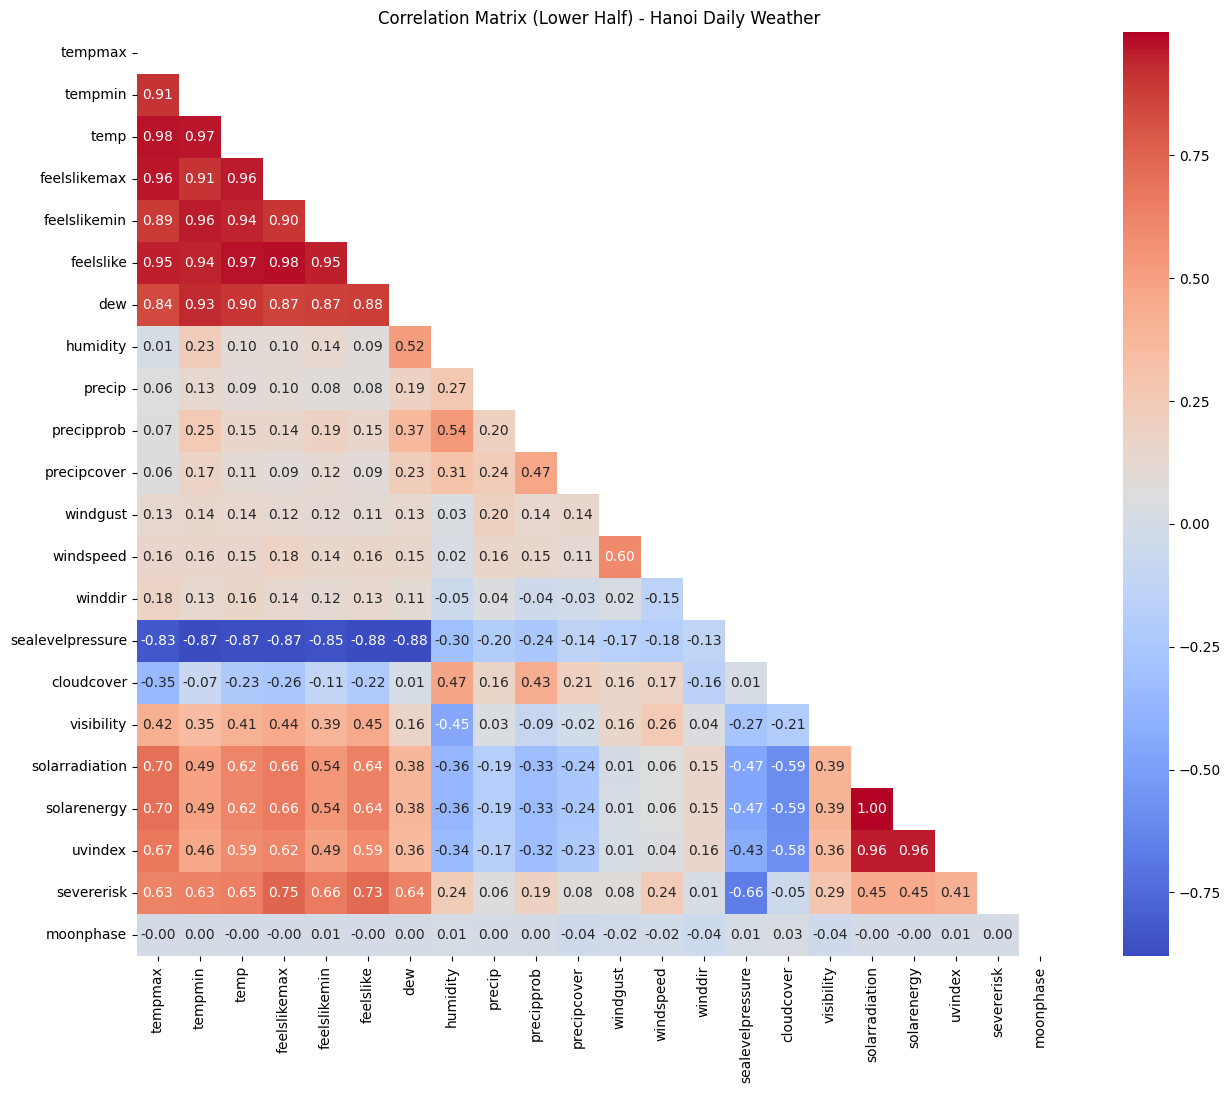

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(16, 12))
numeric_cols = [col for col in numeric_df.columns if col not in ['snow', 'snowdepth']]
corr = df_daily[numeric_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,
            mask=mask,
            cmap='coolwarm',
            annot=True,
            fmt='.2f',
            square=True)

plt.title('Correlation Matrix (Lower Half) - Hanoi Daily Weather')
plt.show()


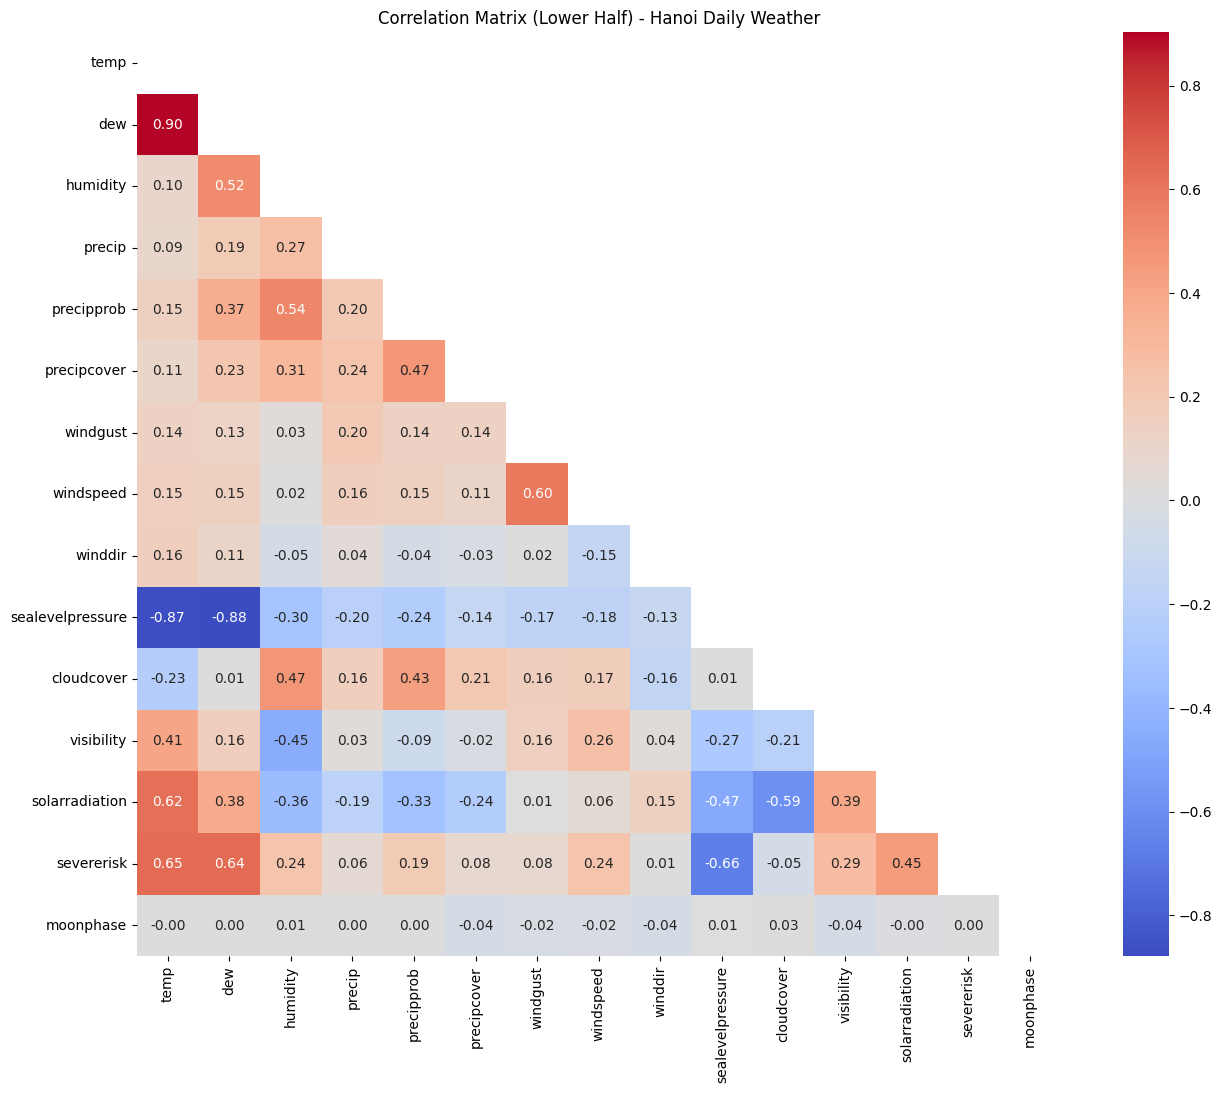

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))

numeric_cols = [col for col in numeric_df.columns if col not in ['snow', 'snowdepth', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'uvindex', 'solarenergy']]
corr = df_daily[numeric_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,
            mask=mask,
            cmap='coolwarm',
            annot=True,
            fmt='.2f',
            square=True)

plt.title('Correlation Matrix (Lower Half) - Hanoi Daily Weather')
plt.show()

# 🧩 Correlation Matrix Analysis – Hanoi Daily Weather Data

## 🔹 1. Introduction  
The correlation matrix was computed on the **numeric variables** of the dataset `Hanoi Daily.csv`, including meteorological factors such as **temperature, humidity, air pressure, solar radiation, and wind**.  

The goal is to identify the **strength and direction of linear relationships** among variables, helping to select the most informative features for forecasting models or climate analysis.

---

## 🔹 2. Top Correlated Variable Pairs (|r| > 0.7)

| Variable Pair | Correlation Coefficient | Relationship | Note |
|----------------|--------------------------|---------------|------|
| `tempmax` ↔ `temp` | **0.98** | Very strong, positive | As max temperature increases, mean temperature rises |
| `tempmin` ↔ `temp` | **0.97** | Very strong, positive | Strong linear relationship |
| `feelslikemax` ↔ `feelslike` | **0.98** | Very strong, positive | Perceived temperature closely matches actual temperature |
| `temp` ↔ `feelslike` | **0.97** | Very strong, positive | Highly redundant information |
| `dew` ↔ `humidity` | **≈0.90** | Very strong, positive | High humidity corresponds to high dew point |
| `solarradiation` ↔ `solarenergy` | **0.9999** | Almost identical | One can be dropped to reduce redundancy |
| `solarenergy` ↔ `uvindex` | **0.96** | Very strong, positive | Strong sunlight correlates with high UV index |
| `sealevelpressure` ↔ `temp` | **-0.87** | Strong, negative | Air pressure drops as temperature rises |

---

## 🔹 3. General Observations  

### 🌡️ Temperature Group
Variables `tempmax`, `tempmin`, `temp`, `feelslikemax`, and `feelslike` show very high correlations → they all capture the same physical phenomenon: **temperature variation**.  
👉 Keep only **one representative**, such as `temp`.

---

### ☀️ Solar Radiation Group  
`solarradiation`, `solarenergy`, and `uvindex` are almost perfectly correlated.  
👉 In modeling, keep just one (e.g., `solarenergy`) as a proxy for **solar intensity**.

---

### 🌬️ Pressure vs. Temperature  
A strong negative correlation between `sealevelpressure` and temperature variables reflects basic atmospheric physics:  
> When air warms up, it expands and pressure drops — often leading to unstable weather conditions (rain, storms, or wind).

---

### 🌧️ Rainfall, Wind, and Clouds  
Variables like `precip`, `windspeed`, `cloudcover`, and `visibility` have weak correlations with temperature variables → they are **independent features** capturing unique weather aspects.  
👉 Keep all of them to improve predictive model performance.

---

## 🔹 4. Conclusions  
- The correlation matrix reveals potential **multicollinearity** among meteorological features.  
- It’s advisable to **remove or combine variables** with correlations above 0.9 to avoid redundancy.  
- Independent groups such as precipitation, wind, and cloud cover remain essential for **forecasting extreme weather events**.  

# 🌡️ How Variables Combine to Detect or Predict Hanoi Temperature

## 🔹 1. Overview  
The temperature in Hanoi can be estimated or predicted by combining several strongly related meteorological variables.  
Based on the correlation matrix, the temperature (`temp`) shows strong or moderate relationships with **humidity, dew point, air pressure, solar radiation, and wind** — all of which influence the daily thermal conditions.

Phần đồ thị tham khảo thêm thôi nhé (t vẽ để xem có giúp hình dung hơn không thoy). Nếu mọi người đọc tiếp thì đọc luôn mục 2 nhé.

## 🔹 2. Key Influencing Variables

In [17]:
latest_date = df_daily['datetime'].max()
start_date = latest_date - pd.DateOffset(years= 1)
df_last_year = df_daily[df_daily['datetime'] >= start_date].copy()

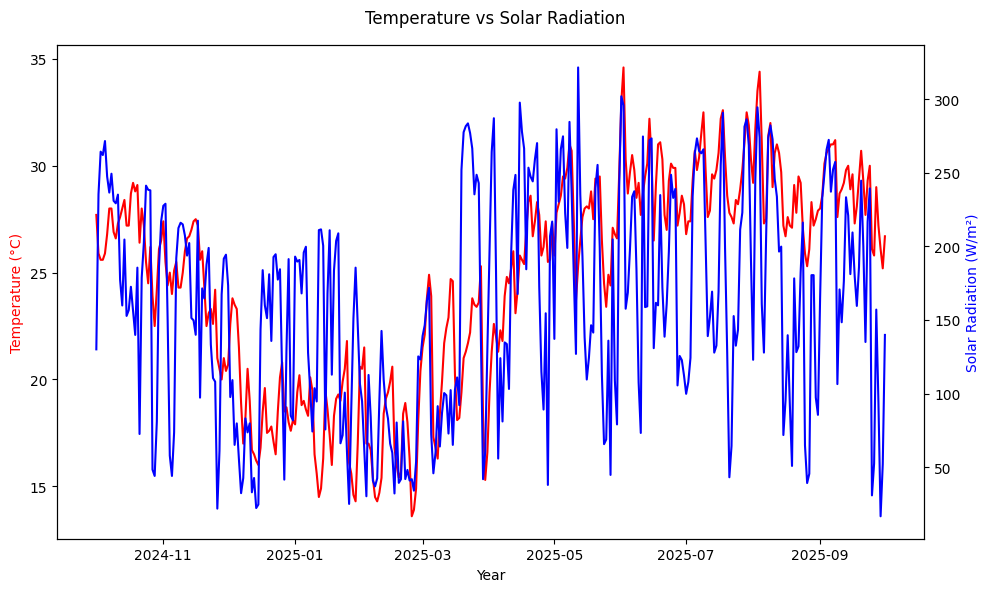

In [18]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_last_year['datetime'], df_last_year['temp'], color='red', label='Temperature')
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)', color='red')

ax2 = ax1.twinx()
ax2.plot(df_last_year['datetime'], df_last_year['solarradiation'], color='blue', label='Solar Radiation')
ax2.set_ylabel('Solar Radiation (W/m²)', color='blue')

fig.suptitle('Temperature vs Solar Radiation')
fig.tight_layout()
plt.show()

###  Solar Radiation and UV Index  
- Variables: `solarradiation`, `solarenergy`, `uvindex`  
- These have the strongest **positive correlation** with temperature.  
- More solar radiation → higher surface heating → higher temperature.  
- In predictive modeling, these variables explain **daytime warming**.

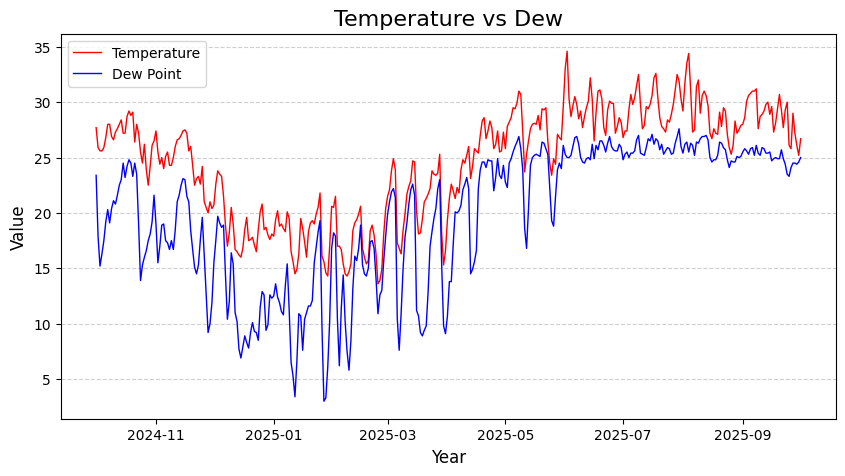

In [19]:
plt.figure(figsize=(10, 5))

plt.plot(df_last_year['datetime'], df_last_year['temp'], color='red', label='Temperature', linewidth=1)

plt.plot(df_last_year['datetime'], df_last_year['dew'], color='blue', label='Dew Point', linewidth=1)


plt.title('Temperature vs Dew', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6, axis='y')

plt.show()

###  Humidity and Dew Point  
- Variables: `humidity`, `dew`  
- **Moderate to strong positive correlation**.  
- High humidity means the air contains more moisture, which traps heat and increases the perceived temperature (`feelslike`).  
- Useful for predicting **nighttime and early-morning temperature stability**.
- The dew point is useful measure of humidity:
    + Higher dew point = more moisture in the air, making it feel humid and sticky.
    + Lower dew point = clean air, often making conditions feel more comfortable.

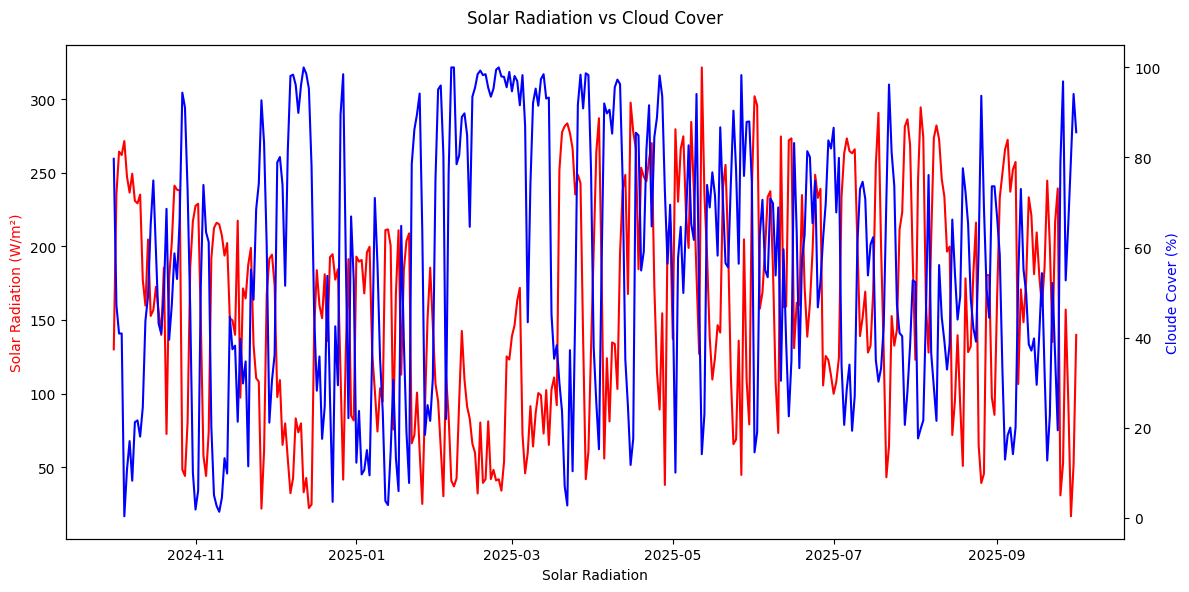

In [20]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_last_year['datetime'], df_last_year['solarradiation'], color='red', label='Solar Radiation')
ax1.set_xlabel('Solar Radiation')
ax1.set_ylabel('Solar Radiation (W/m²)', color='red')

ax2 = ax1.twinx()
ax2.plot(df_last_year['datetime'], df_last_year['cloudcover'], color='blue', label='Cloud Cover')
ax2.set_ylabel('Cloude Cover (%)', color='blue')

fig.suptitle('Solar Radiation vs Cloud Cover')
fig.tight_layout()
plt.show()


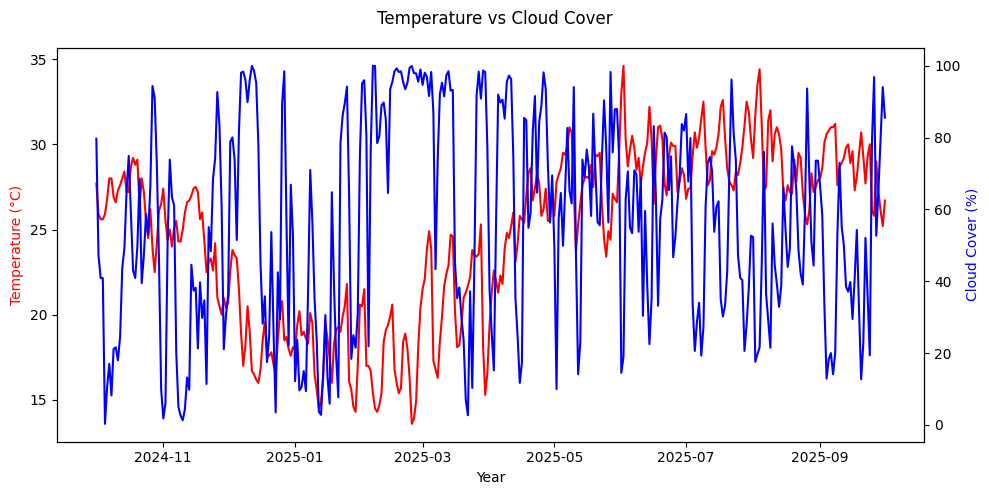

In [21]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(df_last_year['datetime'], df_last_year['temp'], color='red', label='Temperature')
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)', color='red')

ax2 = ax1.twinx()
ax2.plot(df_last_year['datetime'], df_last_year['cloudcover'], color='blue', label='Cloud Cover')
ax2.set_ylabel('Cloud Cover (%)', color='blue')

fig.suptitle('Temperature vs Cloud Cover')
fig.tight_layout()
plt.show()


###  Cloud Cover and Visibility  
- Variables: `cloudcover`, `visibility`  
- **Inverse relation** with solar radiation.  
- More clouds → less sunlight reaching the ground → cooler daytime temperature.  
- Often used together with solar variables to correct for **radiation blocking** effects.
- Cloud Cover and Visibility can be good measure of each other:
    + Lower Cloud Cover = Higher Visibility
    + Higher Cloud Cover = Lower Visibility
    + For example, if the cloud cover is high, it means that the sunlight is blocked, humidity and moisture can be high which lead to low visibility and vice versa.

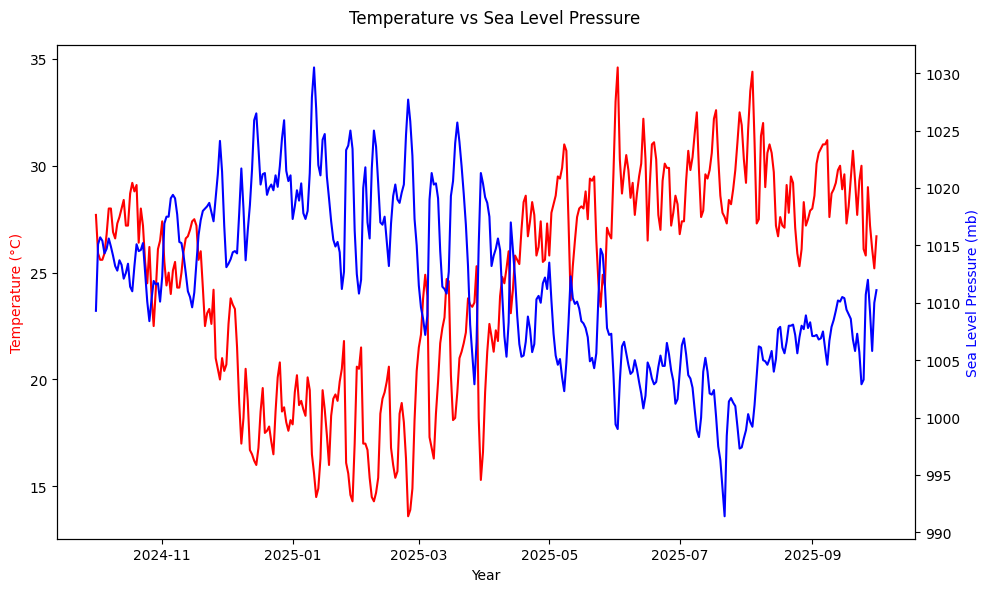

In [22]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_last_year['datetime'], df_last_year['temp'], color='red', label='Temperature')
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)', color='red')

ax2 = ax1.twinx()
ax2.plot(df_last_year['datetime'], df_last_year['sealevelpressure'], color='blue', label='Sea Level Pressure')
ax2.set_ylabel('Sea Level Pressure (mb)', color='blue')

fig.suptitle('Temperature vs Sea Level Pressure')
fig.tight_layout()
plt.show()


###  Air Pressure  
- Variable: `sealevelpressure`  
- **Strong negative correlation (≈-0.87)** with temperature.  
- When temperature rises, air expands and pressure drops.  
- This variable is useful for identifying **weather pattern transitions** (e.g., hot low-pressure systems).


## 🔹 3. Combined Predictive Structure  

Temperature can be modeled as a function of several predictors:
\[
T = f(\text{Solar Radiation, Humidity, Air Pressure, Cloud Cover, Wind})
\]

In practice, these relationships can be captured through:
- **Multiple Linear Regression** for linear effects  
- **Random Forest or Gradient Boosting** for nonlinear interactions  
- **Time-series models** (e.g., LSTM, Prophet) to account for seasonal and diurnal patterns  


## 🔹 4. Summary  

| Variable Group | Relationship to Temperature | Role in Detection |
|----------------|------------------------------|-------------------|
| Solar radiation & UV | Positive | Main driver of heating |
| Humidity & Dew point | Positive | Moisture-driven heat retention |
| Air pressure | Negative | Inverse physical response |
| Cloud cover & Visibility | Negative | Controls sunlight penetration |
| Wind | Mixed | Regulates surface heat dispersion |

**In conclusion:**  
By integrating solar intensity, humidity, air pressure, cloud cover, and wind data, we can effectively detect and forecast temperature variations in Hanoi.  
These factors jointly represent the **energy balance of the atmosphere**, which directly governs how hot or cold a day becomes.


# **Step 3**

## **Determine feature type**

In [23]:
df_daily.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [24]:
# Phần này chuyển thành bảng trong markdown thì ôk hơn
continuous_features = [
    'tempmax','tempmin','temp','feelslikemax','feelslikemin','feelslike',
    'dew','humidity','precip','precipprob','precipcover','snow','snowdepth',
    'windgust','windspeed','sealevelpressure','cloudcover','visibility',
    'solarradiation','solarenergy'
]

discrete_features = ['uvindex','severerisk']

cyclical_features = ['winddir','moonphase']

categorical_features = ['preciptype','conditions','description','icon']

datetime_features = ['datetime', 'sunset', 'sunrise']

In [25]:
# Convert data type for datetime columns
df_daily['datetime'] = pd.to_datetime(df_daily['datetime'], errors='coerce')
df_daily['sunrise']  = pd.to_datetime(df_daily['sunrise'], errors='coerce')
df_daily['sunset']   = pd.to_datetime(df_daily['sunset'], errors='coerce')

In [26]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927 entries, 0 to 3926
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              3927 non-null   object        
 1   datetime          3927 non-null   datetime64[ns]
 2   tempmax           3927 non-null   float64       
 3   tempmin           3927 non-null   float64       
 4   temp              3927 non-null   float64       
 5   feelslikemax      3927 non-null   float64       
 6   feelslikemin      3927 non-null   float64       
 7   feelslike         3927 non-null   float64       
 8   dew               3927 non-null   float64       
 9   humidity          3927 non-null   float64       
 10  precip            3927 non-null   float64       
 11  precipprob        3927 non-null   int64         
 12  precipcover       3927 non-null   float64       
 13  preciptype        2885 non-null   object        
 14  snow              3927 n

## **Handle missing value**

In [27]:
# Check columns with missing values
nan_counts = df_daily.isnull().sum()
cols_with_nan = nan_counts[nan_counts > 0]
cols_with_nan

,0
preciptype,1042
severerisk,2566


### **preciptype**

In [28]:
df_daily['preciptype'].value_counts(dropna=False)

,count
preciptype,
rain,2885
NaN,1042


**`preciptype`**: This column describes the type(s) of precipitation observed (e.g., rain, snow, sleet).  
- When no precipitation occurred, this field naturally remains **NaN**.  
- Moreover, since the dataset also includes the `precipprob` column (showing 0% if no precipitation occurred, or 100% if it did), there are two reasonable ways to handle these missing values:
  1. Replace NaN in `preciptype` with `'none'` to explicitly indicate the absence of precipitation.  
  2. Combine `preciptype` and `precipprob` into a new binary feature indicating **whether precipitation occurred or not** (e.g., `has_precip = 0/1`).

In [29]:
df_daily['preciptype'] = df_daily['preciptype'].fillna('none')
df_daily['preciptype'] = df_daily['preciptype'].replace({'rain': 1, 'none': 0})
df_daily['preciptype'].value_counts(dropna=False)

/tmp/ipython-input-3934160314.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_daily['preciptype'] = df_daily['preciptype'].replace({'rain': 1, 'none': 0})


,count
preciptype,
1,2885
0,1042


### **severerisk**

In [30]:
df_daily['severerisk'].value_counts(dropna=False)

,count
severerisk,
NaN,2566
10.0,738
60.0,248
30.0,247
75.0,106
100.0,11
5.0,5
15.0,3
8.0,3


In [31]:
df_daily['severerisk'].isnull().sum()/df_daily['severerisk'].shape[0]

np.float64(0.6534250063661828)

**`severerisk`**: This column represents the risk level of severe weather events (in %).  
- Missing values here likely indicate that **no severe weather risk was detected or forecasted** for those days.  
- It could be reasonable to fill NaN values with **0.0** to represent “no risk.”  (nma cái này không được giải thích trong cái data documentation của họ nên cũng không chắc có đúng 0.0 là o có risk hay không --> xem xét bỏ cột đó đi tại cx có hơn 65% là NaN rồi)
- However, since over **65% of the entries are missing**, it should be considered to **drop this column entirely** to avoid introducing bias or excessive noise into the dataset.


## **Encoding features**

### **Encode cyclical features using sin/cos transform**

In [32]:
df_daily['winddir'].value_counts()

,count
winddir,
120.2,11
116.5,10
118.4,9
96.8,9
114.5,9
...,...
272.6,1
117.9,1
144.7,1


Two features named `winddir` (wind direction) and `moonphase` are cyclical in nature, meaning their values wrap around. For example, 0° is very close to 360°, and a moonphase of 0.99 is close to 0.01.

If we use these values directly, the model may incorrectly interpret them as far apart.

To preserve this circular relationship, we should transform them using sine and cosine functions. This encoding allows the model to correctly understand proximity within cycles and capture periodic patterns in weather behavior.

In [33]:
df_daily['winddir_sin'] = np.sin(2 * np.pi * df_daily['winddir'] / 360)
df_daily['winddir_cos'] = np.cos(2 * np.pi * df_daily['winddir'] / 360)

### **Encode categorical features using one-hot/label encoder**

For categorical features, we evaluated the frequency and semantic meaning of each variable.

In [34]:
df_daily['icon'].value_counts()

,count
icon,
rain,2834
partly-cloudy-day,811
clear-day,206
cloudy,76


In [35]:
df_daily['conditions'].value_counts()

,count
conditions,
"Rain, Partially cloudy",2306
Partially cloudy,811
"Rain, Overcast",508
Clear,206
Overcast,76
Rain,20


In [36]:
df_daily['description'].head(10)

,description
0,Clear conditions throughout the day.
1,Partly cloudy throughout the day.
2,Partly cloudy throughout the day.
3,Partly cloudy throughout the day with a chance...
4,Cloudy skies throughout the day.
5,Partly cloudy throughout the day with late aft...
6,Cloudy skies throughout the day with rain in t...
7,Partly cloudy throughout the day with afternoo...
8,Partly cloudy throughout the day with early mo...
9,Cloudy skies throughout the day with a chance ...


## **Removing irrelevant or constant features**

### **Constant columns**

In [37]:
constant_cols = [col for col in df_daily.columns if df_daily[col].nunique() == 1]
constant_cols

['name', 'snow', 'snowdepth']

In [38]:
for col in constant_cols:
    print(df_daily[col].value_counts(), '\n')

name
Hanoi    3927
Name: count, dtype: int64 

snow
0    3927
Name: count, dtype: int64 

snowdepth
0    3927
Name: count, dtype: int64 



In [39]:
df_daily.drop(columns=constant_cols, inplace=True)

The columns `name`, `snow`, and `snowdepth` are removed because they contain only a **single unique value** throughout the dataset:

- **`name`**: All records correspond to the same location (“Hanoi”), so this column provides no variability or additional information for analysis or prediction.  
- **`snow`** and **`snowdepth`**: Both columns contain only zeros, indicating that no snowfall events occurred in Hanoi during the entire observation period.  

Since these variables do not contribute any useful variation or predictive power, they are classified as **constant features** and therefore dropped from the dataset.

### **Irrelevant columns (non-informative columns)**

In [40]:
df_daily['stations'].value_counts()

,count
stations,
"48820099999,48823099999,48825099999,48831099999,VVNB",3507
"VMI0000VVNB,48820099999,48825099999,VVNB,VMM00048825",149
"48820099999,48823099999,48825099999,48831099999,VVNB,remote",100
"VMI0000VVNB,48820099999,48823099999,48825099999,VVNB,VMM00048825",47
"VMI0000VVNB,VMM00048823,VMM00048831,VVNB,VMM00048825",28
"VMI0000VVNB,48820099999,48823099999,48825099999,VMM00048823,VVNB,VMM00048825",16
"48820099999,VVNB",13
"48820099999,48823099999,48825099999,48831099999,remote,VVNB",9
VVNB,8


In [41]:
df_daily['stations'].nunique()

32

The `stations` column lists combinations of weather station IDs that contributed data for each record. Although it contains **32 unique combinations**, almost **90% of all rows (3507/3927) share the same main group** of stations (`48820099999,48823099999,48825099999,48831099999,VVNB`). The remaining combinations appear only a few times and represent slight variations of the same nearby stations.

This column does **not provide meaningful variability** or predictive information — all stations belong to the same city (Hanoi), and the small differences between station codes do not affect temperature, humidity, or precipitation patterns.

Moreover, the column consists of **complex multi-code strings**, making it impractical to encode for analysis or modeling. Since the dataset already includes the `name` column identifying the city, `stations` is **redundant and can be safely removed**.

In [42]:
pd.set_option('display.max_colwidth', None)
df_daily[['icon', 'conditions', 'description']].head(10)

,icon,conditions,description
0,clear-day,Clear,Clear conditions throughout the day.
1,partly-cloudy-day,Partially cloudy,Partly cloudy throughout the day.
2,partly-cloudy-day,Partially cloudy,Partly cloudy throughout the day.
3,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance of rain throughout the day.
4,cloudy,Overcast,Cloudy skies throughout the day.
5,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with late afternoon rain.
6,rain,"Rain, Overcast",Cloudy skies throughout the day with rain in the morning and afternoon.
7,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with afternoon rain.
8,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with early morning rain.
9,rain,"Rain, Overcast",Cloudy skies throughout the day with a chance of rain throughout the day.


Among the three columns — `icon`, `conditions`, and `description` — only **`conditions`** should be kept:

- **`icon`** provides short categorical codes (e.g., `"clear-day"`, `"rain"`, `"partly-cloudy-day"`) mainly used for visualization or UI purposes. It does not add meaningful analytical value.  
- **`description`** is a full-sentence narrative (e.g., “Partly cloudy throughout the day with afternoon rain.”) that conveys the same information as `conditions` but in a verbose, text-heavy format. It is redundant and not suitable for quantitative modeling.  
- **`conditions`** offers concise and interpretable categorical labels (e.g., “Clear”, “Rain, Overcast”) that effectively summarize the weather situation and can be easily encoded for machine learning or statistical analysis.

Therefore, **only the `conditions` column is retained**, while `icon` and `description` are removed as non-informative or redundant.


In [43]:
df_daily.drop(columns=['icon', 'description', 'stations', 'solarenergy', 'moonphase', 'feelslikemax',
       'feelslikemin', 'feelslike', 'severerisk', 'uvindex'], inplace=True)

chưa giải thích


In [44]:
df_daily.columns

Index(['datetime', 'tempmax', 'tempmin', 'temp', 'dew', 'humidity', 'precip',
       'precipprob', 'precipcover', 'preciptype', 'windgust', 'windspeed',
       'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'sunrise', 'sunset', 'conditions', 'winddir_sin',
       'winddir_cos'],
      dtype='object')

# **Train-test split**

In [45]:
n = len(df_daily)
train_end = int(0.7 * n)
val_end = int(0.85 * n)
df_daily = df_daily.set_index('datetime')
train_df = df_daily.iloc[:train_end].copy()
val_df   = df_daily.iloc[train_end:val_end].copy()
test_df  = df_daily.iloc[val_end:].copy()
print('train/val/test lengths:', len(train_df), len(val_df), len(test_df))

train/val/test lengths: 2748 589 590


In [46]:
print(f'\n--- Data Splitting ---')
print(f'Train/Val/Test lengths: {len(train_df)} / {len(val_df)} / {len(test_df)}')
print(f'Train Start/End: {train_df.index.min()} / {train_df.index.max()}')
print(f'Val Start/End:   {val_df.index.min()} / {val_df.index.max()}')
print(f'Test Start/End:  {test_df.index.min()} / {test_df.index.max()}')


--- Data Splitting ---
Train/Val/Test lengths: 2748 / 589 / 590
Train Start/End: 2015-01-01 00:00:00 / 2022-07-10 00:00:00
Val Start/End:   2022-07-11 00:00:00 / 2024-02-19 00:00:00
Test Start/End:  2024-02-20 00:00:00 / 2025-10-01 00:00:00


# **Feature engineering**

In [47]:
# --- HÀM HỖ TRỢ ---

def encode_cyclical(df, col, max_val):
    """Hàm mã hóa cyclical (lấy từ prompt trước của bạn)"""
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

def create_all_features(df, target_col, horizon, lag_features, lags, roll_features, windows):
    """
    Hàm gộp TẤT CẢ các bước tạo feature (thay thế cho class fe)
    *** ĐÃ CẬP NHẬT CHO MULTI-OUTPUT ***
    """
    df_new = df.copy()

    # 1. Time features (Giả sử index là datetime)
    df_new['year'] = df_new.index.year
    df_new['month'] = df_new.index.month
    df_new['day_of_year'] = df_new.index.dayofyear
    df_new['day_of_week'] = df_new.index.dayofweek
    df_new['quarter'] = df_new.index.quarter

    # 2. Cyclical Time features
    df_new = encode_cyclical(df_new, 'month', 12)
    df_new = encode_cyclical(df_new, 'day_of_year', 366)
    df_new = encode_cyclical(df_new, 'day_of_week', 7)
    df_new = df_new.drop(columns=['month', 'day_of_year', 'day_of_week'], errors='ignore')

    # 3. Lag features
    for feature in lag_features:
        if feature in df_new.columns:
            for lag in lags:
                df_new[f'{feature}_lag{lag}'] = df_new[feature].shift(lag)

    # 4. Rolling features (shift(1) để chống data leakage)
    for feature in roll_features:
        if feature in df_new.columns:
            series_shifted = df_new[feature].shift(1)
            for w in windows:
                rolling_window = series_shifted.rolling(window=w)
                df_new[f'{feature}_roll{w}_mean'] = rolling_window.mean()
                df_new[f'{feature}_roll{w}_std'] = rolling_window.std()

    # 5. DERIVED FEATURES (PHẦN ĐƯỢC THÊM LẠI)
    if 'humidity' in df_new.columns:
        df_new['humidity_change'] = df_new['humidity'].diff()

    if 'tempmax' in df_new.columns and 'tempmin' in df_new.columns:
        df_new['temp_range'] = df_new['tempmax'] - df_new['tempmin']
    df_new = df_new.drop(columns=['tempmax', 'tempmin'], errors ='ignore')

    if 'sunrise' in df_new.columns and 'sunset' in df_new.columns:
        sr = pd.to_datetime(df_new['sunrise'], errors='coerce')
        ss = pd.to_datetime(df_new['sunset'], errors='coerce')
        valid_times = sr.notna() & ss.notna()
        df_new['day_length_hour'] = np.nan
        df_new.loc[valid_times, 'day_length_hour'] = (ss[valid_times] - sr[valid_times]).dt.total_seconds() / 3600
        df_new = df_new.drop(columns=['sunrise', 'sunset'])

    # 6. Create Target (*** PHẦN ĐÃ THAY ĐỔI ***)
    # Tạo 5 cột target: t+1, t+2, t+3, t+4, t+5
    for i in range(1, horizon + 1):
        df_new[f'target_{target_col}_t+{i}'] = df_new[target_col].shift(-i)
    df_new = df_new.drop(columns = target_col)
    # Drop the original columns used for rolling and lag features after creating the features
    df_new = df_new.drop(columns = roll_features, errors='ignore')
    df_new = df_new.drop(columns = lag_features, errors='ignore')
    return df_new

In [48]:
print(f'\n--- Bước 3: Feature Engineering (Chạy riêng lẻ từng tập) ---')

# Xác định các tham số
TARGET_COL = 'temp'
HORIZON = 5
lag_cols = ['humidity', 'dew', 'precip',
            'precipprob', 'precipcover', 'solarradiation',
            'sealevelpressure', 'windspeed', 'winddir',
            'windgust', 'cloudcover', 'visibility']
lag_cols_existing = [col for col in lag_cols if col in df_daily.columns]
roll_cols = ['humidity', 'windspeed', 'dew', 'cloudcover']
roll_windows = range(7, 91, 7)
lags = range(7, 91, 7) # Lấy từ code gốc của bạn

# (Toàn bộ phần tính max_lookback và padding đã bị xóa)

# 3.1 Xử lý train_df (chạy độc lập)
print("Đang xử lý train_df...")
train_featured = create_all_features(train_df, TARGET_COL, HORIZON, lag_cols_existing, lags, roll_cols, roll_windows)

# 3.2 Xử lý val_df (chạy độc lập)
print("Đang xử lý val_df...")
val_featured = create_all_features(val_df, TARGET_COL, HORIZON, lag_cols_existing, lags, roll_cols, roll_windows)

# 3.3 Xử lý test_df (chạy độc lập)
print("Đang xử lý test_df...")
test_featured = create_all_features(test_df, TARGET_COL, HORIZON, lag_cols_existing, lags, roll_cols, roll_windows)

# --- BƯỚC 4: DROPNA VÀ TÁCH X/y ---
print(f'\n--- Bước 4: DropNA và Tách X/y ---')

# ⚠️ LƯU Ý QUAN TRỌNG VỀ LOGIC MỚI:
# Theo yêu cầu của bạn, .dropna() bây giờ sẽ:
# 1. Xóa các hàng CUỐI của mỗi tập (do thiếu target t+1 đến t+5).
# 2. Xóa các hàng ĐẦU của MỖI TẬP (do thiếu lag/rolling).
#    Ví dụ: max_lookback (14 lag + 1 shift) = 15.
#    => train_final, val_final, và test_final sẽ MẤT đi 15 HÀNG ĐẦU TIÊN
#       của chúng sau bước này.

# Dropna TRÊN TỪNG TẬP
train_final = train_featured.dropna()
val_final = val_featured.dropna()
test_final = test_featured.dropna()

print(f'Train (final) rows: {len(train_final)}')
print(f'Val (final) rows: {len(val_final)}')
print(f'Test (final) rows: {len(test_final)}')

# Tách X, y (*** PHẦN ĐÃ THAY ĐỔI ***)

# 1. Tạo danh sách các cột target
target_names = [f'target_{TARGET_COL}_t+{i}' for i in range(1, HORIZON + 1)]
print(f"Đang tách {len(target_names)} cột target: {target_names}")

# 2. Tách X (loại bỏ tất cả các cột target)
X_train = train_final.drop(columns=target_names)
y_train = train_final[target_names] # y_train bây giờ là DataFrame

X_val = val_final.drop(columns=target_names)
y_val = val_final[target_names] # y_val bây giờ là DataFrame

X_test = test_final.drop(columns=target_names)
y_test = test_final[target_names] # y_test bây giờ là DataFrame

# --- BƯỚC 5: PREPROCESSING (FIT TRÊN TRAIN, TRANSFORM TẤT CẢ) ---
print(f'\n--- Bước 5: Fit Preprocessor (Scaling + Encoding) ---')

# Xác định các cột (dựa trên các feature đã tạo)
categorical_cols = ['conditions', 'preciptype']
categorical_cols_existing = [col for col in categorical_cols if col in X_train.columns]

# Lấy tất cả các cột SỐ (loại trừ cột categorical)
numeric_cols = [col for col in X_train.columns if col not in categorical_cols_existing]

# 1. Tạo Preprocessor
# numeric_transformer: Scale các cột số
numeric_transformer = StandardScaler()
# categorical_transformer: OneHotEncode các cột phân loại
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Sử dụng ColumnTransformer để áp dụng đúng transformer cho đúng cột
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols_existing)
    ],
    remainder='passthrough' # Giữ lại các cột không được liệt kê (nếu có)
)

# 2. FIT preprocessor CHỈ TRÊN X_TRAIN
print("Fit preprocessor trên X_train...")
preprocessor.fit(X_train)

# 3. TRANSFORM cả 3 tập
print("Transform X_train, X_val, X_test...")
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Lấy tên cột sau khi transform (quan trọng!)
encoded_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols_existing)
final_feature_names = numeric_cols + list(encoded_cat_cols)

# Chuyển đổi mảng numpy trở lại thành DataFrame (để dễ xem)
X_train_processed = pd.DataFrame(X_train_processed, columns=final_feature_names, index=X_train.index)
X_val_processed = pd.DataFrame(X_val_processed, columns=final_feature_names, index=X_val.index)
X_test_processed = pd.DataFrame(X_test_processed, columns=final_feature_names, index=X_test.index)


--- Bước 3: Feature Engineering (Chạy riêng lẻ từng tập) ---
Đang xử lý train_df...
Đang xử lý val_df...


/tmp/ipython-input-1227934842.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[f'{feature}_lag{lag}'] = df_new[feature].shift(lag)
/tmp/ipython-input-1227934842.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[f'{feature}_lag{lag}'] = df_new[feature].shift(lag)
/tmp/ipython-input-1227934842.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

Đang xử lý test_df...


/tmp/ipython-input-1227934842.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[f'{feature}_roll{w}_mean'] = rolling_window.mean()
/tmp/ipython-input-1227934842.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[f'{feature}_roll{w}_std'] = rolling_window.std()
/tmp/ipython-input-1227934842.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 


--- Bước 4: DropNA và Tách X/y ---


/tmp/ipython-input-1227934842.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[f'{feature}_roll{w}_std'] = rolling_window.std()
/tmp/ipython-input-1227934842.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[f'{feature}_roll{w}_mean'] = rolling_window.mean()
/tmp/ipython-input-1227934842.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

Train (final) rows: 2659
Val (final) rows: 500
Test (final) rows: 501
Đang tách 5 cột target: ['target_temp_t+1', 'target_temp_t+2', 'target_temp_t+3', 'target_temp_t+4', 'target_temp_t+5']

--- Bước 5: Fit Preprocessor (Scaling + Encoding) ---
Fit preprocessor trên X_train...
Transform X_train, X_val, X_test...


In [49]:
target_names = [f'target_{TARGET_COL}_t+{i}' for i in range(1, HORIZON + 1)]

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

models = {}
predictions = {}
metrics = {}

for target_col in target_names:
    print(f"\n🔹 Đang huấn luyện mô hình cho {target_col} ...")

    # Tạo model riêng (bạn có thể đổi sang LightGBM, XGB, Linear, v.v.)
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

    # Fit
    model.fit(X_train_processed, y_train[target_col])

    # Lưu model
    models[target_col] = model

    # Dự báo trên val/test
    y_val_pred = model.predict(X_val_processed)
    y_test_pred = model.predict(X_test_processed)

    # Lưu dự báo
    predictions[target_col] = {
        'val': y_val_pred,
        'test': y_test_pred
    }

    # Tính metric
    mae = mean_absolute_error(y_val[target_col], y_val_pred)
    r2 = r2_score(y_val[target_col], y_val_pred)

    metrics[target_col] = {'MAE': mae, 'R2': r2}
    print(f"✅ {target_col}: MAE={mae:.3f}, R²={r2:.3f}")



🔹 Đang huấn luyện mô hình cho target_temp_t+1 ...
✅ target_temp_t+1: MAE=1.732, R²=0.816

🔹 Đang huấn luyện mô hình cho target_temp_t+2 ...
✅ target_temp_t+2: MAE=2.033, R²=0.755

🔹 Đang huấn luyện mô hình cho target_temp_t+3 ...
✅ target_temp_t+3: MAE=2.261, R²=0.705

🔹 Đang huấn luyện mô hình cho target_temp_t+4 ...
✅ target_temp_t+4: MAE=2.297, R²=0.692

🔹 Đang huấn luyện mô hình cho target_temp_t+5 ...
✅ target_temp_t+5: MAE=2.312, R²=0.695


In [51]:
metrics_df = pd.DataFrame(metrics).T
print("\n--- Hiệu suất từng mô hình (VAL set) ---")
print(metrics_df)



--- Hiệu suất từng mô hình (VAL set) ---
                      MAE        R2
target_temp_t+1  1.731749  0.815822
target_temp_t+2  2.032955  0.755454
target_temp_t+3  2.260559  0.704512
target_temp_t+4  2.296823  0.692235
target_temp_t+5  2.311683  0.694609



=== Metrics per horizon & average (VAL) ===
           horizon       MAE      RMSE    MAPE(%)   sMAPE(%)
0  target_temp_t+1  1.731749  2.213425   8.191702   7.957289
1  target_temp_t+2  2.032955  2.550106   9.518699   9.260166
2  target_temp_t+3  2.260559  2.802057  10.581148  10.388788
3  target_temp_t+4  2.296823  2.858948  10.728408  10.560005
4  target_temp_t+5  2.311683  2.847305  10.716110  10.587772
5          AVERAGE  2.126754  2.654368   9.947213   9.750804

=== Metrics per horizon & average (TEST) ===
           horizon       MAE      RMSE   MAPE(%)  sMAPE(%)
0  target_temp_t+1  1.501762  1.870373  6.179558  6.191379
1  target_temp_t+2  1.669172  2.048186  6.888558  6.835849
2  target_temp_t+3  1.728421  2.130992  7.197572  7.046092
3  target_temp_t+4  1.746710  2.159331  7.288576  7.117846
4  target_temp_t+5  1.728926  2.148466  7.224812  7.053837
5          AVERAGE  1.674998  2.071470  6.955815  6.849001

=== Sample compare (VAL, head) ===
            actual_target_temp_t+

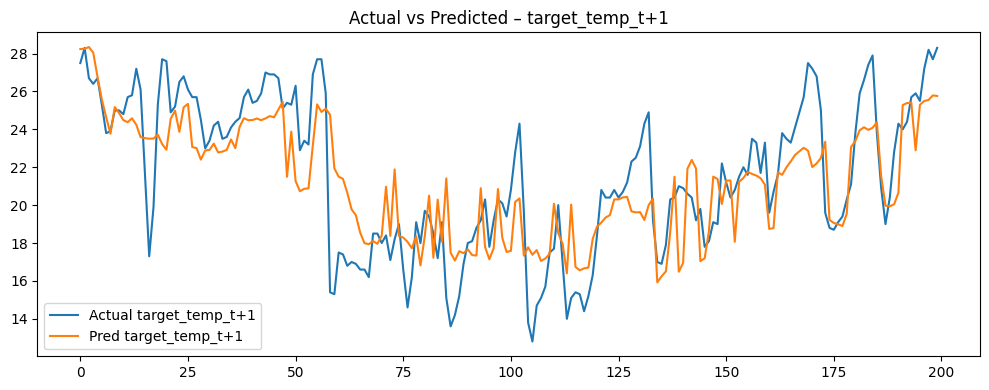

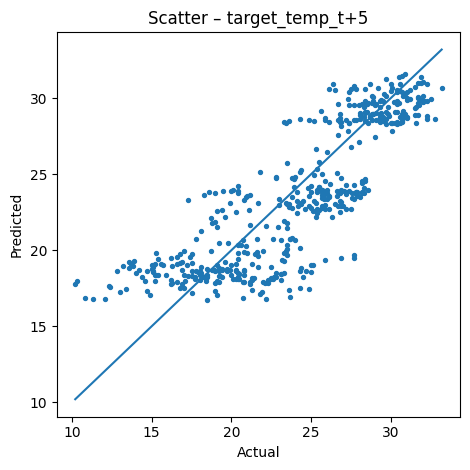

In [52]:
# === EVALUATION FOR SEPARATE MODELS (Multi-horizon, one model per horizon) ===
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ----- 0) Build pred_df từ dict models -----
def build_pred_df_separate(models: dict,
                           X_proc: pd.DataFrame,
                           y_like: pd.DataFrame,
                           target_names: list):
    """
    Trả về DataFrame dự báo có cùng index/columns với y_like.
    models: dict {target_col: fitted_model}
    X_proc: features đã transform (val/test)
    y_like: DataFrame dùng để lấy index/shape/columns chuẩn (val/test)
    target_names: danh sách cột mục tiêu theo thứ tự t+1..t+H
    """
    preds = {}
    for col in target_names:
        if col not in models:
            raise KeyError(f"Không tìm thấy model cho {col} trong 'models'.")
        preds[col] = models[col].predict(X_proc)
    pred_df = pd.DataFrame(preds, index=y_like.index)
    # Đảm bảo đúng thứ tự cột
    pred_df = pred_df[target_names]
    return pred_df

# ----- 1) Hàm metric bổ sung -----
def mape(y_true, y_pred, eps=1e-6):
    return (np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))).mean() * 100.0

def smape(y_true, y_pred, eps=1e-6):
    return (2.0 * np.abs(y_true - y_pred) / np.maximum(np.abs(y_true) + np.abs(y_pred), eps)).mean() * 100.0

# ----- 2) Tính MAE / RMSE / MAPE / sMAPE theo từng horizon + trung bình -----
def evaluate_by_horizon(y_df: pd.DataFrame, pred_df: pd.DataFrame):
    rows = []
    for col in y_df.columns:
        y_t = y_df[col].values
        y_p = pred_df[col].values
        mae  = mean_absolute_error(y_t, y_p)
        rmse = np.sqrt(mean_squared_error(y_t, y_p))
        mape_val  = mape(y_t, y_p)
        smape_val = smape(y_t, y_p)
        rows.append({
            "horizon": col,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE(%)": mape_val,
            "sMAPE(%)": smape_val,
        })

    metrics_df = pd.DataFrame(rows)

    # Sắp xếp theo số t+N nếu cần
    def _hnum(c):
        # trích số sau 't+'
        try:
            return int(str(c).split('t+')[-1])
        except:
            return 10**9
    metrics_df = metrics_df.sort_values(by="horizon", key=lambda s: s.map(_hnum)).reset_index(drop=True)

    # Dòng trung bình
    metrics_df.loc[len(metrics_df)] = {
        "horizon": "AVERAGE",
        "MAE": metrics_df["MAE"].mean(),
        "RMSE": metrics_df["RMSE"].mean(),
        "MAPE(%)": metrics_df["MAPE(%)"].mean(),
        "sMAPE(%)": metrics_df["sMAPE(%)"].mean(),
    }
    return metrics_df

# ----- 3) Ghép bảng so sánh (actual vs predicted) -----
def make_compare_table(y_df: pd.DataFrame, pred_df: pd.DataFrame, n=10):
    compare = pd.concat(
        [y_df.add_prefix("actual_"), pred_df.add_prefix("pred_")],
        axis=1
    )
    return compare.head(n)

# ----- 4) Vẽ nhanh -----
def plot_actual_vs_pred(y_df: pd.DataFrame, pred_df: pd.DataFrame, horizon_col: str, n_points=200):
    plt.figure(figsize=(10,4))
    plt.plot(y_df[horizon_col].iloc[:n_points].values, label=f"Actual {horizon_col}")
    plt.plot(pred_df[horizon_col].iloc[:n_points].values, label=f"Pred {horizon_col}")
    plt.title(f"Actual vs Predicted – {horizon_col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_scatter(y_df: pd.DataFrame, pred_df: pd.DataFrame, horizon_col: str, s=8):
    plt.figure(figsize=(4.8,4.8))
    plt.scatter(y_df[horizon_col].values, pred_df[horizon_col].values, s=s)
    # Đường chéo y=x
    mn = min(y_df[horizon_col].min(), pred_df[horizon_col].min())
    mx = max(y_df[horizon_col].max(), pred_df[horizon_col].max())
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Scatter – {horizon_col}")
    plt.tight_layout()
    plt.show()

# ----- 5) Xuất CSV kèm datetime (tuỳ chọn) -----
def export_predictions_with_datetime(pred_df: pd.DataFrame, path="forecast_with_datetime.csv"):
    df_out = pred_df.copy()
    # nếu index là datetime, giữ lại
    df_out["datetime"] = pred_df.index
    cols = ["datetime"] + [c for c in df_out.columns if c != "datetime"]
    df_out = df_out[cols]
    df_out.to_csv(path, index=False)
    return path


# ==========================
# ===== CÁCH SỬ DỤNG =======
# ==========================
# 0) Xây pred_df cho VAL và TEST từ 'models'
pred_df_val  = build_pred_df_separate(models, X_val_processed,  y_val,  target_names)
pred_df_test = build_pred_df_separate(models, X_test_processed, y_test, target_names)

# 1) Tính metric (VAL)
metrics_val = evaluate_by_horizon(y_val[target_names], pred_df_val[target_names])
print("\n=== Metrics per horizon & average (VAL) ===")
print(metrics_val)

# 2) (tuỳ chọn) Tính metric (TEST)
metrics_test = evaluate_by_horizon(y_test[target_names], pred_df_test[target_names])
print("\n=== Metrics per horizon & average (TEST) ===")
print(metrics_test)

# 3) Bảng so sánh 10 dòng đầu (VAL)
compare_head_val = make_compare_table(y_val[target_names], pred_df_val[target_names], n=10)
print("\n=== Sample compare (VAL, head) ===")
print(compare_head_val)

# 4) Vẽ nhanh (ví dụ t+1 và t+5) trên VAL
plot_actual_vs_pred(y_val, pred_df_val, horizon_col=target_names[0], n_points=200)   # t+1
plot_scatter(y_val,        pred_df_val, horizon_col=target_names[-1], s=8)           # t+5

# 5) (Tuỳ chọn) Xuất CSV kèm datetime (VAL)
# out_path = export_predictions_with_datetime(pred_df_val, path="forecast_val_with_datetime.csv")
# print("Saved:", out_path)


In [53]:
y_train

,target_temp_t+1,target_temp_t+2,target_temp_t+3,target_temp_t+4,target_temp_t+5
datetime,,,,,
2015-03-26,22.0,23.2,24.6,25.8,26.5
2015-03-27,23.2,24.6,25.8,26.5,26.7
2015-03-28,24.6,25.8,26.5,26.7,27.8
2015-03-29,25.8,26.5,26.7,27.8,28.0
2015-03-30,26.5,26.7,27.8,28.0,27.9
...,...,...,...,...,...
2022-07-01,30.6,31.2,32.6,30.4,28.1
2022-07-02,31.2,32.6,30.4,28.1,27.6
2022-07-03,32.6,30.4,28.1,27.6,27.5


In [54]:
# --- BƯỚC 6: OPTUNA + FEATURE SELECTION + RIDGE REGRESSION RIÊNG CHO TỪNG HORIZON ---
print(f'\n--- Bước 6: Optuna Fine-tuning + SelectKBest + Ridge (riêng cho từng horizon) ---')

!pip install optuna
import optuna
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import joblib
import os

# Tạo thư mục lưu model
os.makedirs("ridge_models", exist_ok=True)

# Danh sách horizon
horizons = [1, 2, 3, 4, 5]
target_names = [f'target_temp_t+{h}' for h in horizons]

# Lưu kết quả
best_models = {}
best_selectors = {}
best_params = {}
y_pred_val_all = np.zeros(y_val.shape)
mae_per_horizon = {}

print(f"Đang tối ưu 5 mô hình với Optuna (mỗi horizon riêng)...")

def objective(trial, h, target_col):
    # --- Gợi ý tham số ---
    k = trial.suggest_int('k', 20, 100)  # Số feature chọn
    alpha = trial.suggest_float('alpha', 0.01, 10.0, log=True)

    # --- Feature Selection ---
    selector = SelectKBest(f_regression, k=k)
    X_train_sel = selector.fit_transform(X_train_processed, y_train[target_col])
    X_val_sel = selector.transform(X_val_processed)

    # --- Model ---
    model = Ridge(alpha=alpha, random_state=42)
    model.fit(X_train_sel, y_train[target_col])

    # --- Dự đoán + MAE ---
    y_pred = model.predict(X_val_sel)
    mae = mean_absolute_error(y_val[target_col], y_pred)

    return mae

# --- Vòng lặp Optuna cho từng horizon ---
for i, h in enumerate(horizons):
    target_col = target_names[i]
    print(f"\nHorizon t+{h}: Đang chạy Optuna (n_trials=30)...")

    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, h, target_col), n_trials=30, show_progress_bar=True)

    # Lấy tham số tốt nhất
    best_k = study.best_params['k']
    best_alpha = study.best_params['alpha']
    best_mae = study.best_value

    print(f"   → Best params: k={best_k}, alpha={best_alpha:.4f} | Val MAE = {best_mae:.3f}°C")

    # Huấn luyện lại với tham số tốt nhất
    selector = SelectKBest(f_regression, k=best_k)
    X_train_sel = selector.fit_transform(X_train_processed, y_train[target_col])
    X_val_sel = selector.transform(X_val_processed)
    X_test_sel = selector.transform(X_test_processed)

    model = Ridge(alpha=best_alpha, random_state=42)
    model.fit(X_train_sel, y_train[target_col])

    # Dự đoán
    y_pred_val = model.predict(X_val_sel)
    y_pred_test = model.predict(X_test_sel)

    # Lưu
    best_models[h] = model
    best_selectors[h] = selector
    best_params[h] = {'k': best_k, 'alpha': best_alpha}
    y_pred_val_all[:, i] = y_pred_val
    mae_per_horizon[h] = best_mae

    # Lưu model + selector
    joblib.dump(model, f"ridge_models/ridge_h{h}.pkl")
    joblib.dump(selector, f"ridge_models/selector_h{h}.pkl")

# --- BƯỚC 7: ĐÁNH GIÁ TỔNG THỂ TRÊN VALIDATION ---
print(f'\n--- Bước 7: Đánh giá tổng thể (Validation) ---')

overall_mae_val = mean_absolute_error(y_val, y_pred_val_all)
overall_r2_val = r2_score(y_val, y_pred_val_all, multioutput='variance_weighted')

print(f"Overall Validation MAE: {overall_mae_val:.3f}°C")
print(f"Overall Validation R²: {overall_r2_val:.3f}")

print("\nChi tiết MAE (Validation):")
for h in horizons:
    print(f"   t+{h}: {mae_per_horizon[h]:.3f}°C")

# --- BƯỚC 8: DỰ ĐOÁN & ĐÁNH GIÁ TRÊN TEST ---
print(f'\n--- Bước 8: Dự đoán & Đánh giá trên Test ---')

y_pred_test_all = np.zeros(y_test.shape)

for i, h in enumerate(horizons):
    selector = best_selectors[h]
    model = best_models[h]
    X_test_sel = selector.transform(X_test_processed)
    y_pred_test_all[:, i] = model.predict(X_test_sel)

# Đánh giá
test_mae = mean_absolute_error(y_test, y_pred_test_all)
test_r2 = r2_score(y_test, y_pred_test_all, multioutput='variance_weighted')

print(f"Test MAE (trung bình 5 ngày): {test_mae:.3f}°C")
print(f"Test R²: {test_r2:.3f}")

print("\nMAE trên Test theo ngày:")
for h in horizons:
    mae_h = mean_absolute_error(y_test[f'target_temp_t+{h}'], y_pred_test_all[:, h-1])
    print(f"   t+{h}: {mae_h:.3f}°C")

# --- IN THAM SỐ TỐI ƯU ---
print(f'\n--- Tham số tối ưu cho từng horizon ---')
for h in horizons:
    p = best_params[h]
    print(f"   t+{h}: k={p['k']}, alpha={p['alpha']:.4f}")


--- Bước 6: Optuna Fine-tuning + SelectKBest + Ridge (riêng cho từng horizon) ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.4 MB/s eta 0:00:00


[I 2025-11-04 13:27:48,974] A new study created in memory with name: no-name-e4ecacaf-ea40-4076-bfbd-9dc7deb61a0e


Đang tối ưu 5 mô hình với Optuna (mỗi horizon riêng)...

Horizon t+1: Đang chạy Optuna (n_trials=30)...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-04 13:27:49,059] Trial 0 finished with value: 2.2232438269598997 and parameters: {'k': 40, 'alpha': 0.2514929504110233}. Best is trial 0 with value: 2.2232438269598997.
[I 2025-11-04 13:27:49,092] Trial 1 finished with value: 1.8178942037989616 and parameters: {'k': 89, 'alpha': 0.010442999365561527}. Best is trial 1 with value: 1.8178942037989616.
[I 2025-11-04 13:27:49,136] Trial 2 finished with value: 2.2299968345126002 and parameters: {'k': 28, 'alpha': 0.04783846274109177}. Best is trial 1 with value: 1.8178942037989616.
[I 2025-11-04 13:27:49,196] Trial 3 finished with value: 2.1977007249252436 and parameters: {'k': 58, 'alpha': 3.554515768045076}. Best is trial 1 with value: 1.8178942037989616.
[I 2025-11-04 13:27:49,235] Trial 4 finished with value: 2.3074074089052705 and parameters: {'k': 20, 'alpha': 0.08005615701309617}. Best is trial 1 with value: 1.8178942037989616.
[I 2025-11-04 13:27:49,269] Trial 5 finished with value: 2.2347780477215373 and parameters: {'k':

[I 2025-11-04 13:27:50,396] A new study created in memory with name: no-name-c89eb039-7b2b-4df6-892e-3dc247e608e4


[I 2025-11-04 13:27:50,306] Trial 28 finished with value: 1.803314272654759 and parameters: {'k': 92, 'alpha': 2.397396591587398}. Best is trial 11 with value: 1.7945540209989637.
[I 2025-11-04 13:27:50,347] Trial 29 finished with value: 2.2166819216516953 and parameters: {'k': 66, 'alpha': 0.40451471707597175}. Best is trial 11 with value: 1.7945540209989637.
   → Best params: k=99, alpha=1.8706 | Val MAE = 1.795°C

Horizon t+2: Đang chạy Optuna (n_trials=30)...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-04 13:27:50,455] Trial 0 finished with value: 2.3038295917088445 and parameters: {'k': 55, 'alpha': 0.019462312194612415}. Best is trial 0 with value: 2.3038295917088445.
[I 2025-11-04 13:27:50,491] Trial 1 finished with value: 2.2630811351233056 and parameters: {'k': 83, 'alpha': 0.1707406405732401}. Best is trial 1 with value: 2.2630811351233056.
[I 2025-11-04 13:27:50,539] Trial 2 finished with value: 2.2808381433994422 and parameters: {'k': 33, 'alpha': 0.039974549986215205}. Best is trial 1 with value: 2.2630811351233056.
[I 2025-11-04 13:27:50,589] Trial 3 finished with value: 2.3123888822700156 and parameters: {'k': 50, 'alpha': 0.017322176799380137}. Best is trial 1 with value: 2.2630811351233056.
[I 2025-11-04 13:27:50,623] Trial 4 finished with value: 2.297948220230757 and parameters: {'k': 21, 'alpha': 0.09318518689085892}. Best is trial 1 with value: 2.2630811351233056.
[I 2025-11-04 13:27:50,677] Trial 5 finished with value: 2.288679080436629 and parameters: {'k

[I 2025-11-04 13:27:52,309] A new study created in memory with name: no-name-3814f2db-9f0d-4e87-b5dc-7d4b69309454



Horizon t+3: Đang chạy Optuna (n_trials=30)...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-04 13:27:52,482] Trial 0 finished with value: 2.3163769916025276 and parameters: {'k': 28, 'alpha': 1.4430627993730971}. Best is trial 0 with value: 2.3163769916025276.
[I 2025-11-04 13:27:52,583] Trial 1 finished with value: 2.243237976402957 and parameters: {'k': 90, 'alpha': 8.96128984041913}. Best is trial 1 with value: 2.243237976402957.
[I 2025-11-04 13:27:52,645] Trial 2 finished with value: 2.3259696241950887 and parameters: {'k': 45, 'alpha': 1.919642134114488}. Best is trial 1 with value: 2.243237976402957.
[I 2025-11-04 13:27:52,711] Trial 3 finished with value: 2.3174170079253837 and parameters: {'k': 24, 'alpha': 0.09962530316225035}. Best is trial 1 with value: 2.243237976402957.
[I 2025-11-04 13:27:52,781] Trial 4 finished with value: 2.3165519284025025 and parameters: {'k': 35, 'alpha': 0.1042875806367452}. Best is trial 1 with value: 2.243237976402957.
[I 2025-11-04 13:27:52,860] Trial 5 finished with value: 2.3068635987485275 and parameters: {'k': 94, 'alph

[I 2025-11-04 13:27:54,657] A new study created in memory with name: no-name-1f9ae152-52de-4f2c-a2fa-3a0f572aaf54


[I 2025-11-04 13:27:54,553] Trial 28 finished with value: 2.237792233816951 and parameters: {'k': 100, 'alpha': 6.095385439460542}. Best is trial 28 with value: 2.237792233816951.
[I 2025-11-04 13:27:54,601] Trial 29 finished with value: 2.263165333798044 and parameters: {'k': 94, 'alpha': 6.323297759164391}. Best is trial 28 with value: 2.237792233816951.
   → Best params: k=100, alpha=6.0954 | Val MAE = 2.238°C

Horizon t+4: Đang chạy Optuna (n_trials=30)...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-04 13:27:54,738] Trial 0 finished with value: 2.2671191566657924 and parameters: {'k': 80, 'alpha': 5.32033160995641}. Best is trial 0 with value: 2.2671191566657924.
[I 2025-11-04 13:27:54,787] Trial 1 finished with value: 2.324803385952707 and parameters: {'k': 33, 'alpha': 1.38701830345818}. Best is trial 0 with value: 2.2671191566657924.
[I 2025-11-04 13:27:54,838] Trial 2 finished with value: 2.295453999438288 and parameters: {'k': 63, 'alpha': 1.5651320135561397}. Best is trial 0 with value: 2.2671191566657924.
[I 2025-11-04 13:27:54,872] Trial 3 finished with value: 2.3314006358441772 and parameters: {'k': 24, 'alpha': 0.06276878032620581}. Best is trial 0 with value: 2.2671191566657924.
[I 2025-11-04 13:27:54,908] Trial 4 finished with value: 2.343283057605689 and parameters: {'k': 39, 'alpha': 0.1502996295580363}. Best is trial 0 with value: 2.2671191566657924.
[I 2025-11-04 13:27:54,959] Trial 5 finished with value: 2.331557739324858 and parameters: {'k': 45, 'alph

[I 2025-11-04 13:27:56,161] A new study created in memory with name: no-name-54713f8d-95c9-494e-99e7-ba805ca82016


[I 2025-11-04 13:27:56,117] Trial 29 finished with value: 2.339382057388189 and parameters: {'k': 98, 'alpha': 2.8666963490293087}. Best is trial 21 with value: 2.263346276132813.
   → Best params: k=80, alpha=8.8211 | Val MAE = 2.263°C

Horizon t+5: Đang chạy Optuna (n_trials=30)...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-04 13:27:56,206] Trial 0 finished with value: 2.3425827064828875 and parameters: {'k': 69, 'alpha': 0.12402185051018506}. Best is trial 0 with value: 2.3425827064828875.
[I 2025-11-04 13:27:56,246] Trial 1 finished with value: 2.3298760134392653 and parameters: {'k': 77, 'alpha': 0.023933553004800587}. Best is trial 1 with value: 2.3298760134392653.
[I 2025-11-04 13:27:56,290] Trial 2 finished with value: 2.3545802274631074 and parameters: {'k': 53, 'alpha': 0.5337681482761844}. Best is trial 1 with value: 2.3298760134392653.
[I 2025-11-04 13:27:56,329] Trial 3 finished with value: 2.3702238292518114 and parameters: {'k': 45, 'alpha': 0.025147227875384662}. Best is trial 1 with value: 2.3298760134392653.
[I 2025-11-04 13:27:56,351] Trial 4 finished with value: 2.4082229993443707 and parameters: {'k': 20, 'alpha': 5.08860407248496}. Best is trial 1 with value: 2.3298760134392653.
[I 2025-11-04 13:27:56,380] Trial 5 finished with value: 2.3553936404416835 and parameters: {'k':

In [55]:
from sklearn.ensemble import RandomForestRegressor

# --- FEATURE SELECTION (Code của bạn đã sửa) ---
print(f'\n--- Feature Selection dùng RandomForest Importance ---')

# 1. Lấy dữ liệu đã được xử lý (Scaled + OHE) từ BƯỚC 5
X_train_fs = X_train_processed
y_train_fs = y_train # y_train là DataFrame [n_samples, 5]

# 2. Lấy danh sách tên feature từ BƯỚC 5
features_for_selection = final_feature_names

# 3. Kiểm tra NaNs cho DataFrame (dùng .any().any())
if y_train_fs.isnull().any().any():
    print("Warning: NaNs tìm thấy trong target. Đang loại bỏ...")
    valid_target_idx = y_train_fs.dropna().index
    X_train_fs = X_train_fs.loc[valid_target_idx]
    y_train_fs = y_train_fs.loc[valid_target_idx]

# 4. Huấn luyện RandomForest
# (RFRegressor hỗ trợ y là multi-output (DataFrame)
print("Đang huấn luyện RandomForest để lấy feature importances (trung bình trên 5 target)...")
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=10)
rf.fit(X_train_fs, y_train_fs)
print("Huấn luyện hoàn tất.")

# 5. Lấy kết quả importance
# Khi y là multi-output, .feature_importances_ là
# trung bình mức độ quan trọng trên tất cả 5 target
importances = pd.Series(rf.feature_importances_, index=features_for_selection).sort_values(ascending=False)

# 6. Chọn ra N features tốt nhất
N_FEATURES_TO_KEEP = 50 # Bạn có thể thay đổi số này
selected_features = importances.head(N_FEATURES_TO_KEEP).index.tolist()

print(f"\nĐã chọn Top {N_FEATURES_TO_KEEP} features.")
print("Top 10 features và tầm quan trọng (trung bình):")
print(importances.head(10))


# --- LỌC LẠI CÁC TẬP DỮ LIỆU ---
print(f'\n--- Lọc lại X_train/X_val/X_test với {N_FEATURES_TO_KEEP} features ---')

# Dùng danh sách 'selected_features' từ BƯỚC 6 để lọc
X_train_final = X_train_processed[selected_features]
X_val_final = X_val_processed[selected_features]
X_test_final = X_test_processed[selected_features]

print("Đã tạo X_train_final, X_val_final, X_test_final.")
print(f"Kích thước X_train_final: {X_train_final.shape}")


# --- HUẤN LUYỆN MÔ HÌNH (Dùng XGBoost) ---
print("\n--- Sẵn sàng huấn luyện mô hình (Multi-Output XGBoost) ---")

# 1. Tạo mô hình cơ sở (base model)
xgb_base = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=500,
                            learning_rate=0.05,
                            # ... các tham số khác ...
                            )

# 2. Bọc mô hình cơ sở bằng MultiOutputRegressor
multi_output_model = MultiOutputRegressor(xgb_base)

print(f"Bắt đầu huấn luyện 5 mô hình trên {X_train_final.shape[1]} features đã chọn...")
# 3. Fit mô hình trên X_train_FINAL và y_train
multi_output_model.fit(X_train_final, y_train)

print("Huấn luyện hoàn tất!")

# 4. Dự đoán (predict) trên X_val_FINAL
predictions = multi_output_model.predict(X_val_final)
print("\nĐã dự đoán trên tập Val (đã lọc). Kích thước output:", predictions.shape)


--- Feature Selection dùng RandomForest Importance ---
Đang huấn luyện RandomForest để lấy feature importances (trung bình trên 5 target)...
Huấn luyện hoàn tất.

Đã chọn Top 50 features.
Top 10 features và tầm quan trọng (trung bình):
day_of_year_cos    0.298143
dew_roll21_mean    0.210573
dew_roll28_mean    0.175380
day_of_year_sin    0.038573
dew_roll14_mean    0.035962
day_length_hour    0.026040
winddir_cos        0.025193
month_sin          0.007081
dew_roll70_mean    0.007059
dew_roll35_mean    0.005452
dtype: float64

--- Lọc lại X_train/X_val/X_test với 50 features ---
Đã tạo X_train_final, X_val_final, X_test_final.
Kích thước X_train_final: (2659, 50)

--- Sẵn sàng huấn luyện mô hình (Multi-Output XGBoost) ---
Bắt đầu huấn luyện 5 mô hình trên 50 features đã chọn...
Huấn luyện hoàn tất!

Đã dự đoán trên tập Val (đã lọc). Kích thước output: (500, 5)


In [56]:
importances.index.tolist()

['day_of_year_cos',
 'dew_roll21_mean',
 'dew_roll28_mean',
 'day_of_year_sin',
 'dew_roll14_mean',
 'day_length_hour',
 'winddir_cos',
 'month_sin',
 'dew_roll70_mean',
 'dew_roll35_mean',
 'humidity_roll70_std',
 'cloudcover_roll28_mean',
 'cloudcover_roll77_mean',
 'windspeed_roll63_mean',
 'humidity_roll21_std',
 'windspeed_roll21_mean',
 'sealevelpressure_lag70',
 'dew_roll77_mean',
 'sealevelpressure_lag14',
 'dew_roll56_mean',
 'temp_range',
 'dew_roll84_std',
 'humidity_roll7_mean',
 'dew_roll77_std',
 'dew_roll14_std',
 'windspeed_roll28_mean',
 'cloudcover_roll21_mean',
 'cloudcover_roll28_std',
 'cloudcover_roll42_mean',
 'windspeed_roll70_std',
 'cloudcover_roll70_std',
 'cloudcover_roll14_mean',
 'cloudcover_roll49_std',
 'humidity_roll56_std',
 'cloudcover_roll35_std',
 'dew_roll70_std',
 'dew_roll21_std',
 'dew_roll7_mean',
 'windspeed_roll35_mean',
 'cloudcover_roll14_std',
 'humidity_roll14_std',
 'dew_lag56',
 'dew_roll56_std',
 'windspeed_roll14_std',
 'dew_roll49_me


=== Metrics per horizon & average ===
           horizon       MAE      RMSE    MAPE(%)   sMAPE(%)
0  target_temp_t+1  1.804312  2.291039   8.357908   8.252797
1  target_temp_t+2  2.051058  2.574632   9.537048   9.392035
2  target_temp_t+3  2.324157  2.892718  10.848090  10.635866
3  target_temp_t+4  2.419317  2.975922  11.354039  11.043159
4  target_temp_t+5  2.328131  2.912219  10.875858  10.676139
5          AVERAGE  2.185395  2.729306  10.194589   9.999999

=== Sample compare (head) ===
            actual_target_temp_t+1  actual_target_temp_t+2  \
datetime                                                     
2022-10-03                    27.5                    28.3   
2022-10-04                    28.3                    26.7   
2022-10-05                    26.7                    26.4   
2022-10-06                    26.4                    26.7   
2022-10-07                    26.7                    25.3   
2022-10-08                    25.3                    23.8   
2022-10

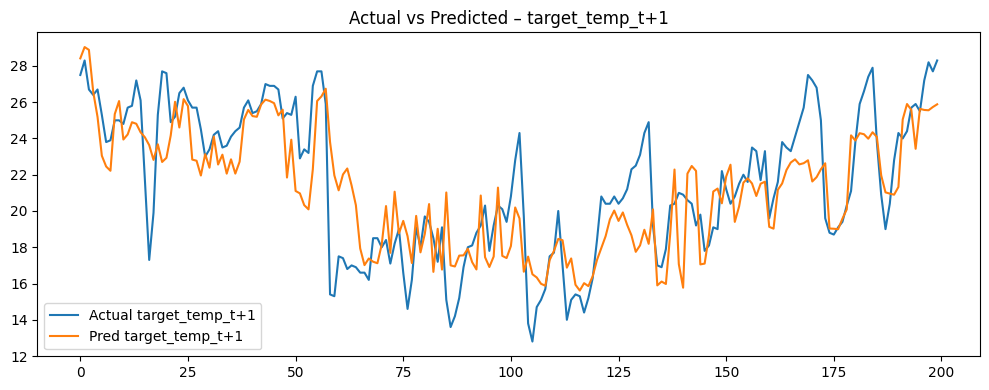

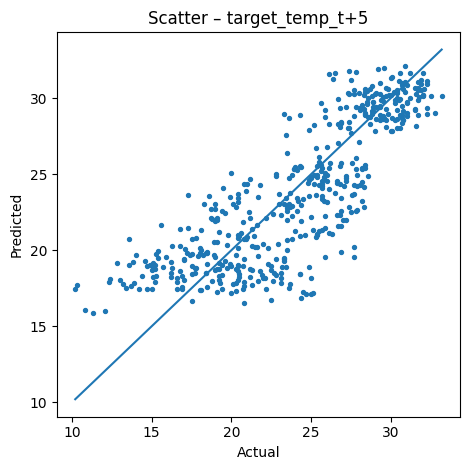

In [60]:

# === EVALUATION FOR MULTI-OUTPUT REGRESSION (Multi-horizon) ===
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ----- 0) Cấu hình tên cột đầu ra & build DataFrame dự đoán kèm datetime
def build_pred_df(predictions, y_val, HORIZON, TARGET_COL):
    """
    predictions: ndarray (n_samples, HORIZON)
    y_val      : DataFrame (n_samples, HORIZON) với cột target theo đúng thứ tự t+1..t+H
    """
    target_names = [f"target_{TARGET_COL}_t+{i}" for i in range(1, HORIZON+1)]
    # Tạo DataFrame dự đoán, căn đúng index & cột của y_val
    pred_df = pd.DataFrame(predictions, columns=target_names, index=y_val.index)
    # (Tuỳ chọn) đảm bảo thứ tự cột khớp y_val nếu bạn đã dùng naming khác:
    # pred_df = pred_df[y_val.columns]  # uncomment nếu cột đã có sẵn trong y_val
    return pred_df, target_names

# ----- 1) Hàm metric bổ sung
def mape(y_true, y_pred, eps=1e-6):
    # MAPE (%). Thêm eps để tránh chia cho 0
    return (np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))).mean() * 100.0

def smape(y_true, y_pred, eps=1e-6):
    # sMAPE (%): 2*|y - yhat| / (|y| + |yhat|)
    return (2.0 * np.abs(y_true - y_pred) / np.maximum(np.abs(y_true) + np.abs(y_pred), eps)).mean() * 100.0

# ----- 2) Tính MAE / RMSE / MAPE / sMAPE theo từng horizon + trung bình
def evaluate_multioutput(y_val: pd.DataFrame, pred_df: pd.DataFrame):
    rows = []
    for col in y_val.columns:
        y_t = y_val[col].values
        y_p = pred_df[col].values

        mae  = mean_absolute_error(y_t, y_p)
        rmse = np.sqrt(mean_squared_error(y_t, y_p))   # ✅ sửa ở đây
        mape_val  = mape(y_t, y_p)
        smape_val = smape(y_t, y_p)

        rows.append({
            "horizon": col,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE(%)": mape_val,
            "sMAPE(%)": smape_val,
        })

    metrics_df = pd.DataFrame(rows)
    metrics_df.loc[len(metrics_df)] = {
        "horizon": "AVERAGE",
        "MAE": metrics_df["MAE"].mean(),
        "RMSE": metrics_df["RMSE"].mean(),
        "MAPE(%)": metrics_df["MAPE(%)"].mean(),
        "sMAPE(%)": metrics_df["sMAPE(%)"].mean(),
    }
    return metrics_df

# ----- 3) Ghép bảng so sánh (actual vs predicted) để xem nhanh
def make_compare_table(y_val: pd.DataFrame, pred_df: pd.DataFrame, n=10):
    compare = pd.concat(
        [y_val.add_prefix("actual_"), pred_df.add_prefix("pred_")],
        axis=1
    )
    return compare.head(n)

# ----- 4) Vẽ vài biểu đồ nhanh
def plot_actual_vs_pred(y_val: pd.DataFrame, pred_df: pd.DataFrame, horizon_col: str, n_points=200):
    """
    Vẽ series thời gian actual vs predicted cho 1 horizon (ví dụ 'target_temp_t+1').
    n_points: số điểm đầu để vẽ (tránh hình quá dài)
    """
    plt.figure(figsize=(10,4))
    plt.plot(y_val[horizon_col].iloc[:n_points].values, label=f"Actual {horizon_col}")
    plt.plot(pred_df[horizon_col].iloc[:n_points].values, label=f"Pred {horizon_col}")
    plt.title(f"Actual vs Predicted – {horizon_col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_scatter(y_val: pd.DataFrame, pred_df: pd.DataFrame, horizon_col: str, s=8):
    """
    Vẽ scatter actual vs predicted cho 1 horizon.
    """
    plt.figure(figsize=(4.8,4.8))
    plt.scatter(y_val[horizon_col].values, pred_df[horizon_col].values, s=s)
    # Đường chéo y=x
    mn = min(y_val[horizon_col].min(), pred_df[horizon_col].min())
    mx = max(y_val[horizon_col].max(), pred_df[horizon_col].max())
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Scatter – {horizon_col}")
    plt.tight_layout()
    plt.show()

# ----- 5) Xuất CSV nếu cần
def export_predictions_with_datetime(pred_df: pd.DataFrame, path="forecast_with_datetime.csv"):
    df_out = pred_df.copy()
    df_out["datetime"] = pred_df.index  # giữ datetime
    # Đưa datetime lên đầu cho đẹp
    cols = ["datetime"] + [c for c in df_out.columns if c != "datetime"]
    df_out = df_out[cols]
    df_out.to_csv(path, index=False)
    return path


# ==========================
# ====== CÁCH SỬ DỤNG ======
# ==========================
# Giả sử bạn đã có:
# - predictions: ndarray shape (n_samples, HORIZON)
# - y_val: DataFrame shape (n_samples, HORIZON), cột theo t+1..t+H
# - HORIZON, TARGET_COL đã định nghĩa

# 0) Build pred_df và đặt đúng cột + index
pred_df, target_names = build_pred_df(predictions, y_val, HORIZON, TARGET_COL)

# 1) Tính metric
metrics_df = evaluate_multioutput(y_val[target_names], pred_df[target_names])
print("\n=== Metrics per horizon & average ===")
print(metrics_df)

# 2) Bảng so sánh 10 dòng đầu (actual vs pred)
compare_head = make_compare_table(y_val[target_names], pred_df[target_names], n=10)
print("\n=== Sample compare (head) ===")
print(compare_head)

# 3) Vẽ nhanh (ví dụ cho t+1 và t+5)
plot_actual_vs_pred(y_val, pred_df, horizon_col=target_names[0], n_points=200)  # t+1
plot_scatter(y_val, pred_df, horizon_col=target_names[-1], s=8)            # t+5

# 4) (Tuỳ chọn) Xuất CSV kèm datetime
# out_path = export_predictions_with_datetime(pred_df)
# print("Saved:", out_path)


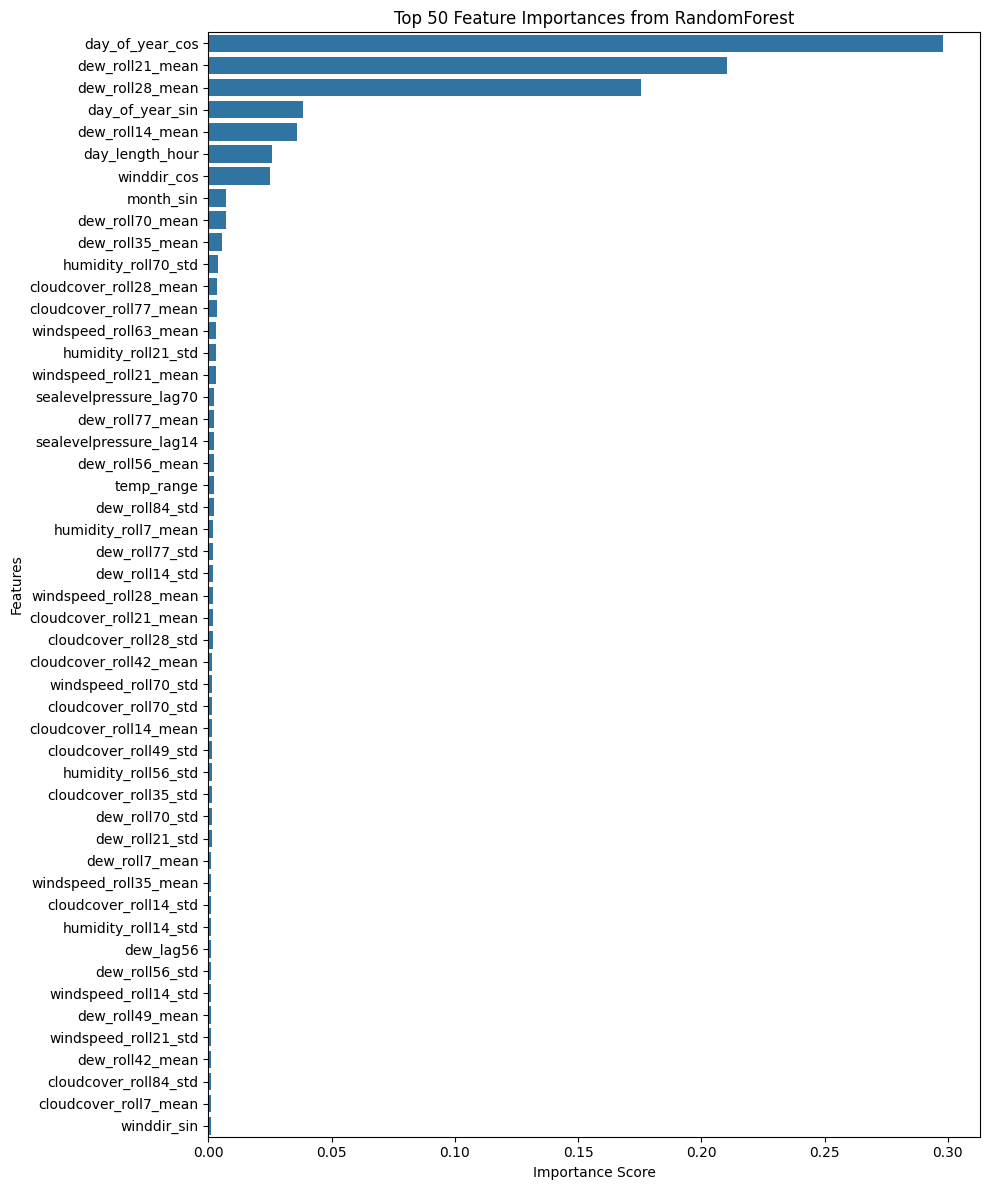

In [61]:
# --- Plot Feature Importances ---
plt.figure(figsize=(10, 12))
sns.barplot(x=importances.head(N_FEATURES_TO_KEEP).values, y=importances.head(N_FEATURES_TO_KEEP).index)
plt.title(f'Top {N_FEATURES_TO_KEEP} Feature Importances from RandomForest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [62]:
x=importances.head(N_FEATURES_TO_KEEP)
x

,0
day_of_year_cos,0.298143
dew_roll21_mean,0.210573
dew_roll28_mean,0.175380
day_of_year_sin,0.038573
dew_roll14_mean,0.035962
day_length_hour,0.026040
winddir_cos,0.025193
month_sin,0.007081
dew_roll70_mean,0.007059
dew_roll35_mean,0.005452


In [63]:
predictions

array([[28.416662, 27.489391, 26.985723, 26.832857, 27.04869 ],
       [29.04017 , 27.41466 , 26.823454, 26.607716, 26.713512],
       [28.885174, 26.93389 , 25.970858, 24.853674, 24.981625],
       ...,
       [19.29281 , 18.234165, 17.910826, 20.006636, 21.403444],
       [19.208271, 19.089031, 17.892466, 20.519419, 20.685343],
       [20.533133, 19.663677, 18.84904 , 19.802036, 20.95257 ]],
      dtype=float32)

In [64]:
y_val

,target_temp_t+1,target_temp_t+2,target_temp_t+3,target_temp_t+4,target_temp_t+5
datetime,,,,,
2022-10-03,27.5,28.3,26.7,26.4,26.7
2022-10-04,28.3,26.7,26.4,26.7,25.3
2022-10-05,26.7,26.4,26.7,25.3,23.8
2022-10-06,26.4,26.7,25.3,23.8,23.9
2022-10-07,26.7,25.3,23.8,23.9,25.0
...,...,...,...,...,...
2024-02-10,19.1,18.5,20.7,21.8,21.3
2024-02-11,18.5,20.7,21.8,21.3,21.3
2024-02-12,20.7,21.8,21.3,21.3,21.3


In [65]:
target_names = [f"target_temp_t+{i}" for i in range(1, HORIZON+1)]

pred_df = pd.DataFrame(
    predictions,
    columns=target_names,
    index=y_val.index   # rất quan trọng: giữ đúng datetime
)


In [66]:
compare_df = pd.concat([y_val, pred_df], axis=1)
compare_df


,target_temp_t+1,target_temp_t+2,target_temp_t+3,target_temp_t+4,target_temp_t+5,target_temp_t+1,target_temp_t+2,target_temp_t+3,target_temp_t+4,target_temp_t+5
datetime,,,,,,,,,,
2022-10-03,27.5,28.3,26.7,26.4,26.7,28.416662,27.489391,26.985723,26.832857,27.048691
2022-10-04,28.3,26.7,26.4,26.7,25.3,29.040171,27.414660,26.823454,26.607716,26.713512
2022-10-05,26.7,26.4,26.7,25.3,23.8,28.885174,26.933889,25.970858,24.853674,24.981625
2022-10-06,26.4,26.7,25.3,23.8,23.9,26.564587,26.997736,25.724951,24.487576,25.324203
2022-10-07,26.7,25.3,23.8,23.9,25.0,25.187555,24.485666,23.595268,24.353016,24.805223
...,...,...,...,...,...,...,...,...,...,...
2024-02-10,19.1,18.5,20.7,21.8,21.3,15.212249,14.473660,15.283122,19.576281,18.681236
2024-02-11,18.5,20.7,21.8,21.3,21.3,15.074912,15.386763,14.909973,19.130220,20.284401
2024-02-12,20.7,21.8,21.3,21.3,21.3,19.292810,18.234165,17.910826,20.006636,21.403444


In [67]:
y_val

,target_temp_t+1,target_temp_t+2,target_temp_t+3,target_temp_t+4,target_temp_t+5
datetime,,,,,
2022-10-03,27.5,28.3,26.7,26.4,26.7
2022-10-04,28.3,26.7,26.4,26.7,25.3
2022-10-05,26.7,26.4,26.7,25.3,23.8
2022-10-06,26.4,26.7,25.3,23.8,23.9
2022-10-07,26.7,25.3,23.8,23.9,25.0
...,...,...,...,...,...
2024-02-10,19.1,18.5,20.7,21.8,21.3
2024-02-11,18.5,20.7,21.8,21.3,21.3
2024-02-12,20.7,21.8,21.3,21.3,21.3
